# **Problem Statement**

Flight departure delays are a critical challenge in the aviation industry. Such delays affect
passenger satisfaction, airline operations, and overall efficiency. You are provided with raw
Excel files (test, train, and weather data) and are tasked with calculating departure delays. Using
these datasets, you will analyze delay patterns and build predictive models to identify key factors
contributing to delays.

# **Objective**

The main goal is to predict departure delays for flights in the test dataset. You will:
1. Analyze the train data, test data, and weather data.
2. Build predictive models based on the train data.
3. Generate predictions for the test data.
4. Submit your predictions to a Kaggle competition for evaluation.

# **Phase 1: Data Preprocessing and Feature Engineering**

# **Read CSV FILES**

In [149]:
!pip install python-docx

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from docx import Document
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

In [151]:
import os

In [152]:
directory_path = '/kaggle/input/weather-dataset/ML-Proj-Dataset/Test'
file_texts = []
test_file_name = []
for filename in os.listdir(directory_path):
    if filename.endswith('.docx'):
        file_path = os.path.join(directory_path, filename)
        document = Document(file_path)
        text = "\n".join([paragraph.text for paragraph in document.paragraphs])
        file_texts.append(text)
        test_file_name.append(filename)

print("Total files:", len(file_texts))


Total files: 71


In [153]:
directory_path = '/kaggle/input/weather-dataset/ML-Proj-Dataset/Train'
file_texts_train = []
train_file_name = []
for filename in os.listdir(directory_path):
    if filename.endswith('.docx'):
        file_path = os.path.join(directory_path, filename)
        document = Document(file_path)
        text = "\n".join([paragraph.text for paragraph in document.paragraphs])
        file_texts_train.append(text)
        train_file_name.append(filename)

print("Total files:", len(file_texts_train))


Total files: 71


In [154]:

#the data is in text so json will convert it into dictionaries, lists and respective pyhton datatypes
#e.g: 1 int, malaika string, 0.77 float etc

def text_to_python_format(text):
    return json.loads(text)
#now name the respectoive columns and give them proper data
def naming_data_train(data, filenames):
    rows = []
    for flight in data:
        row = {
            "File Name": filenames,
            "Type": flight.get("type"),
            "Status": flight.get("status"),
            "Departure IATA Code": flight["departure"].get("iataCode"),
            "Departure ICAO Code": flight["departure"].get("icaoCode"),
            "Departure_Terminal": flight["departure"].get("terminal"),
            "Scheduled_Departure": flight["departure"].get("scheduledTime"),
            "Estimated_Departure": flight["departure"].get("estimatedTime"),
            "Actual_Departure": flight["departure"].get("actualTime"),
            "Estimated_Runway_Departure": flight["departure"].get("estimatedRunway"),
            "Actual_Runway_Departure": flight["departure"].get("actualRunway"),
            "Arrival IATA Code": flight["arrival"].get("iataCode"),
            "Arrival ICAO Code": flight["arrival"].get("icaoCode"),
            "Arrival_Terminal": flight["arrival"].get("terminal"),
            "Arrival_Baggage": flight["arrival"].get("baggage"),
            "Scheduled_Arrival": flight["arrival"].get("scheduledTime"),
            "Estimated_Arrival": flight["arrival"].get("estimatedTime"),
            "Airline_Name": flight["airline"].get("name"),
            "Airline IATA": flight["airline"].get("iataCode"),
            "Airline ICAO": flight["airline"].get("icaoCode"),
            "Flight Number": flight["flight"].get("number"),
            "Flight_IATA_Number": flight["flight"].get("iataNumber"),
            "Flight_ICAO_Number": flight["flight"].get("icaoNumber"),
        }
        # Add codeshared flight info if present
        if "codeshared" in flight:
            row["Codeshared_Type"] = 1
            row["Codeshared_Airline_Name"] = flight["codeshared"]["airline"].get("name")
            row["Codeshared_Airline_IATA"] = flight["codeshared"]["airline"].get("iataCode")
            row["Codeshared_Airline_ICAO"] = flight["codeshared"]["airline"].get("icaoCode")
            row["Codeshared_Flight_Number"] = flight["codeshared"]["flight"].get("number")
            row["Codeshared_Flight_IATA_Number"] = flight["codeshared"]["flight"].get("iataNumber")
            row["Codeshared_Flight_ICAO_Number"] = flight["codeshared"]["flight"].get("icaoNumber")
        else:
            row["Codeshared_Type"] = 0

        rows.append(row)

    return rows

def naming_datatest(data, filenames):
    rows = []
    for flight in data:
        row = {
            "File Name": filenames,
            "Type": flight.get("type"),
            "Status": flight.get("status"),
            "Departure_IATA": flight["departure"].get("iataCode"),
            "Departure_ICAO": flight["departure"].get("icaoCode"),
            "Departure_Terminal": flight["departure"].get("terminal"),
            "Departure_Gate": flight["departure"].get("gate"),
            "Scheduled_Departure": flight["departure"].get("scheduledTime"),
            "Estimated_Runway_Departure": flight["departure"].get("estimatedRunway"),
            "Actual_Runway_Departure": flight["departure"].get("actualRunway"),
            "Arrival_IATA": flight["arrival"].get("iataCode"),
            "Arrival_ICAO": flight["arrival"].get("icaoCode"),
            "Arrival_Terminal": flight["arrival"].get("terminal"),
            "Arrival_Baggage": flight["arrival"].get("baggage"),
            "Scheduled_Arrival": flight["arrival"].get("scheduledTime"),
            "Estimated_Arrival": flight["arrival"].get("estimatedTime"),
            "Airline_Name": flight["airline"].get("name"),
            "Airline_IATA": flight["airline"].get("iataCode"),
            "Airline_ICAO": flight["airline"].get("icaoCode"),
            "Flight_Number": flight["flight"].get("number"),
            "Flight_IATA_Number": flight["flight"].get("iataNumber"),
            "Flight_ICAO_Number": flight["flight"].get("icaoNumber"),
        }
        # Handle codeshare flights
        if "codeshared" in flight:
            row["Codeshared_Type"] = 1
            row["Codeshared_Airline_Name"] = flight["codeshared"]["airline"].get("name")
            row["Codeshared_Airline_IATA"] = flight["codeshared"]["airline"].get("iataCode")
            row["Codeshared_Airline_ICAO"] = flight["codeshared"]["airline"].get("icaoCode")
            row["Codeshared_Flight_Number"] = flight["codeshared"]["flight"].get("number")
            row["Codeshared_Flight_IATA_Number"] = flight["codeshared"]["flight"].get("iataNumber")
            row["Codeshared_Flight_ICAO_Number"] = flight["codeshared"]["flight"].get("icaoNumber")
        else:
            row["Codeshared_Type"] = 0
        rows.append(row)
    return rows

def to_dataframe(data):
    df = pd.DataFrame(data)
    return df

def merge_dataframes(df1, df2):
    merged_df = pd.concat([df1, df2], ignore_index=True)
    return merged_df
def file_to_df(texts_list, files):
  #list containing texts
  df1 = None
  fileno = -1
  for text in texts_list:
    fileno += 1
    flight_data = text_to_python_format(text)
    if flight_data:
      named_flat_data = naming_datatest(flight_data, files[fileno])
      df2 = to_dataframe(named_flat_data)
      if df1 is not None:
        df1 = merge_dataframes(df1, df2)
      else:
        df1 = df2
  return df1
def file_to_df_train(texts_list, files):
  #list containing texts
  df1 = None
  fileno = -1
     
  for text in texts_list:
    fileno += 1
    flight_data = text_to_python_format(text)
    if flight_data:
      named_flat_data = naming_data_train(flight_data, files[fileno])
      df2 = to_dataframe(named_flat_data)
      if df1 is not None:
        df1 = merge_dataframes(df1, df2)
      else:
        df1 = df2
  return df1

def to_csv(df1, csv_file_to_save):
  df1.to_csv(csv_file_to_save, index=False)



In [155]:
testdf = file_to_df(file_texts, test_file_name) 
to_csv(testdf, 'flightsTest.csv')
testforplot = pd.read_csv('flightsTest.csv')

In [156]:
testdata = pd.read_csv('/kaggle/input/malaika/Test_File.csv')

In [157]:
testdata.shape

(12914, 10)

In [158]:
traindf = file_to_df_train(file_texts_train, train_file_name)
to_csv(traindf, 'flightsTrain.csv')

In [159]:
data_train = pd.read_csv('flightsTrain.csv')

In [160]:
def process_weather_column(text, total_days):
    values = text.split()
    values_array = np.array(values[3:], dtype=float)  
    reshaped = values_array.reshape(-1, 3)
    max_values = reshaped[:, 0]
    avg_values = reshaped[:, 1]
    min_values = reshaped[:, 2]
    
    return max_values, avg_values, min_values
def clean_excel_data(file1):
  row=[]
  text = file1['Time'][0]
  time_data = text.strip(' ').split(" ")
  total_days = len(time_data[1:])
  months = [time_data[:1][0] for count in range(total_days)]
  rows={"Time_Month":months,"Time_Day":time_data[1:]}
  for col in file1.columns[1:-1]:
    text = file1[col][0]
    #t = text.strip(' ').split(" ")
    max_values, avg_values, min_values = process_weather_column(text, total_days)
    rows[f"{col}Max"] = max_values
    rows[f"{col}Avg"] = avg_values
    rows[f"{col}Min"] = min_values
  cleaned = pd.DataFrame(rows)
  return cleaned

In [161]:
directory_path = '/kaggle/input/weather-dataset/ML-Proj-Dataset/Weather'
weatherDF = None
count = 0
for filename in os.listdir(directory_path):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(directory_path, filename)
        file1 = pd.read_excel(file_path)
        cleaned_file = clean_excel_data(file1)

        if weatherDF is not None:
            count+=1
            weatherDF = merge_dataframes(weatherDF, cleaned_file)
        else:
            weatherDF = cleaned_file
print("Total files:", count+1)


Total files: 13


In [162]:
weatherDF

Time_Month Time_Day  Temperature (°F)Max  Temperature (°F)Avg  \
0          Sep        1                 97.0                 90.7   
1          Sep        2                 99.0                 91.0   
2          Sep        3                 99.0                 90.3   
3          Sep        4                 99.0                 89.9   
4          Sep        5                 97.0                 87.5   
..         ...      ...                  ...                  ...   
375        Dec       27                 63.0                 52.9   
376        Dec       28                 61.0                 51.9   
377        Dec       29                 55.0                 49.0   
378        Dec       30                 57.0                 50.1   
379        Dec       31                 55.0                 49.2   

     Temperature (°F)Min  Dew Point (°F)Max  Dew Point (°F)Avg  \
0                   82.0               75.0               73.3   
1                   82.0               75.0               72.8   
2                   81.0               75.0               72.5   
3                   82.0               79.0               73.3   
4                   77.0               79.0               71.6   
..                   ...                ...                ...   
375                 43.0               57.0               50.9   
376                 43.0               54.0               50.0   
377                 43.0               50.0               46.7   
378                 43.0               50.0               46.1   
379                 45.0               48.0               45.0   

     Dew Point (°F)Min  Humidity (%)Max  Humidity (%)Avg  Humidity (%)Min  \
0                 72.0             74.0             58.2             47.0   
1                 70.0             70.0             56.4             44.0   
2                 72.0             79.0             56.9             42.0   
3                 68.0             79.0             60.0             37.0   
4                 66.0             84.0             60.4             41.0   
..                 ...              ...              ...              ...   
375               43.0            100.0             93.4             77.0   
376               43.0            100.0             93.6             77.0   
377               43.0            100.0             91.8             82.0   
378               43.0            100.0             87.1             72.0   
379               43.0             93.0             85.7             72.0   

     Wind Speed (mph)Max  Wind Speed (mph)Avg  Wind Speed (mph)Min  \
0                   15.0                  6.4                  0.0   
1                   14.0                  5.8                  0.0   
2                   12.0                  6.3                  0.0   
3                   14.0                  4.8                  0.0   
4                   21.0                  7.4                  0.0   
..                   ...                  ...                  ...   
375                  0.0                  0.0                  0.0   
376                  7.0                  2.2                  0.0   
377                  8.0                  2.3                  0.0   
378                  7.0                  1.4                  0.0   
379                  5.0                  0.1                  0.0   

     Pressure (in)Max  Pressure (in)Avg  Pressure (in)Min  
0                29.0              28.9              28.9  
1                28.9              28.9              28.8  
2                28.9              28.9              28.8  
3                28.9              28.9              28.8  
4                29.0              28.9              28.9  
..                ...               ...               ...  
375              29.5              29.4              29.4  
376              29.4              29.3              29.3  
377              29.4              27.5               0.0  
378             

In [163]:
to_csv(weatherDF, 'weather.csv')

In [164]:
data_wether = pd.read_csv('weather.csv') 

# **1. Data Integration**

● Integrate the weather dataset with the training dataset for any further processing.

In [165]:
'''
train = data_train
test = testdata
weather = data_wether
train['Scheduled_Departure'] = pd.to_datetime(train['Scheduled_Departure'])
train['Month'] = train['Scheduled_Departure'].dt.month
train['Day'] = train['Scheduled_Departure'].dt.day

test['Scheduled Time'] = pd.to_datetime(test['Scheduled Time'])
test['Month'] = test['Scheduled Time'].dt.month
test['Day'] = test['Scheduled Time'].dt.day

month_mapping = {
"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
"Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

weather['Month'] = weather['Time_Month'].map(month_mapping)
weather_cleaned = weather.drop_duplicates(subset=["Month", "Time_Day"])
merged_data = pd.merge(
train,
weather,
left_on=['Month', 'Day'],
right_on=['Month', 'Time_Day'],
how='left'  
)

merged_test_data = pd.merge(
test,
weather,
left_on=['Month', 'Day'],
right_on=['Month', 'Time_Day'],
how='left'  
)

merged_data = merged_data.drop(columns = ['Time_Month', 'Time_Day','Month', 'Day'])
merged_test_data = merged_test_data.drop(columns = ['Time_Month', 'Time_Day','Month', 'Day'])
list1 = ['Estimated_Departure',
       'Actual_Departure', 'Estimated_Runway_Departure',
       'Actual_Runway_Departure', 'Scheduled_Arrival',
       'Estimated_Arrival']
for i in list1:
    merged_data[i] = pd.to_datetime(merged_data[i])
merged_data.to_csv("merged_dataset.csv", index=False)
merged_test_data.head()
'''

'\ntrain = data_train\ntest = testdata\nweather = data_wether\ntrain[\'Scheduled_Departure\'] = pd.to_datetime(train[\'Scheduled_Departure\'])\ntrain[\'Month\'] = train[\'Scheduled_Departure\'].dt.month\ntrain[\'Day\'] = train[\'Scheduled_Departure\'].dt.day\n\ntest[\'Scheduled Time\'] = pd.to_datetime(test[\'Scheduled Time\'])\ntest[\'Month\'] = test[\'Scheduled Time\'].dt.month\ntest[\'Day\'] = test[\'Scheduled Time\'].dt.day\n\nmonth_mapping = {\n"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,\n"Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12\n}\n\nweather[\'Month\'] = weather[\'Time_Month\'].map(month_mapping)\nweather_cleaned = weather.drop_duplicates(subset=["Month", "Time_Day"])\nmerged_data = pd.merge(\ntrain,\nweather,\nleft_on=[\'Month\', \'Day\'],\nright_on=[\'Month\', \'Time_Day\'],\nhow=\'left\'  \n)\n\nmerged_test_data = pd.merge(\ntest,\nweather,\nleft_on=[\'Month\', \'Day\'],\nright_on=[\'Month\', \'Time_Day\'],\nhow=\'left\'  \n)\n\nmerged_data

In [166]:

train = data_train
test = testdata
weather = data_wether
train['Scheduled_Departure'] = pd.to_datetime(train['Scheduled_Departure'])
train['Month'] = train['Scheduled_Departure'].dt.month
train['Day'] = train['Scheduled_Departure'].dt.day

test['Scheduled Time'] = pd.to_datetime(test['Scheduled Time'])
test['Month'] = test['Scheduled Time'].dt.month
test['Day'] = test['Scheduled Time'].dt.day

month_mapping = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

weather['Month'] = weather['Time_Month'].map(month_mapping)

weather_cleaned = weather.drop_duplicates(subset=["Month", "Time_Day"])

merged_data = pd.merge(
    train,
    weather_cleaned,
    left_on=['Month', 'Day'],
    right_on=['Month', 'Time_Day'],
    how='left'
)

merged_test_data = pd.merge(
    test,
    weather_cleaned,
    left_on=['Month', 'Day'],
    right_on=['Month', 'Time_Day'],
    how='left'
)

#merged_test_data = merged_test_data.iloc[:len(test)]  

merged_data = merged_data.drop(columns=['Time_Month', 'Time_Day', 'Month', 'Day'])
merged_test_data = merged_test_data.drop(columns=['Time_Month', 'Time_Day', 'Month', 'Day'])
list1 = ['Estimated_Departure', 'Actual_Departure', 'Estimated_Runway_Departure', 
         'Actual_Runway_Departure', 'Scheduled_Arrival', 'Estimated_Arrival']
for i in list1:
    merged_data[i] = pd.to_datetime(merged_data[i])

merged_data.to_csv("merged_dataset.csv", index=False)
print("Shape of merged_test_data:", merged_test_data.shape)
merged_test_data.head()


Shape of merged_test_data: (12914, 25)


File Name  Flight Number       Type  Status Departure IATA Code  \
0   20.docx           4361  departure  active                 lhe   
1   20.docx           1876  departure  active                 lhe   
2   20.docx           6030  departure  active                 lhe   
3   20.docx            739  departure  active                 lhe   
4   20.docx           3932  departure  active                 lhe   

  Departure ICAO Code      Scheduled Time Arrival IATA Code Arrival ICAO Code  \
0                opla 2024-05-14 00:20:00               dxb              omdb   
1                opla 2024-05-07 04:15:00               ruh              oerk   
2                opla 2024-05-09 03:10:00               doh              othh   
3                opla 2024-05-12 02:50:00               jed              oejn   
4                opla 2024-05-16 04:35:00               auh              omaa   

    Arrival Estimated Time  ...  Dew Point (°F)Min  Humidity (%)Max  \
0  2024-05-14t00:20:00.000  ...               52.0             54.0   
1  2024-05-07t04:15:00.000  ...               45.0             54.0   
2  2024-05-09t03:10:00.000  ...               59.0             62.0   
3  2024-05-12t02:50:00.000  ...               61.0             83.0   
4  2024-05-16t04:35:00.000  ...               57.0             51.0   

   Humidity (%)Avg  Humidity (%)Min  Wind Speed (mph)Max  Wind Speed (mph)Avg  \
0             33.2             18.0                 23.0                  8.0   
1             31.1             13.0                 14.0                  4.5   
2             42.5             27.0                 20.0                  8.2   
3             54.2             34.0                 23.0                 10.5   
4             33.3             19.0                  9.0                  3.9   

   Wind Speed (mph)Min  Pressure (in)Max  Pressure (in)Avg  Pressure (in)Min  
0                  0.0              29.1              29.0              29.0  
1                  0.0              29.0              28.9              28.9  
2                  0.0              28.9              28.9              28.8  
3                  3.0              29.1              29.1              28.9  
4                  0.0              29.1              29.0              28.9  

[5 rows x 25 columns]

In [167]:
merged_test_data.shape

(12914, 25)

In [168]:
train = merged_data    
test = merged_test_data 

# **2. Data Cleaning and Transformation**
1. Handle Missing Values.
2. Format Time Fields:
  
  ○ Convert time fields (e.g., Scheduled, Actual, Estimated Time) into a standard
datetime format for consistency.

In [169]:
test['Arrival Estimated Time'] = pd.to_datetime(test['Arrival Estimated Time'])

In [170]:
train = pd.read_csv('merged_dataset.csv') 

In [171]:
train.columns

Index(['File Name', 'Type', 'Status', 'Departure IATA Code',
       'Departure ICAO Code', 'Departure_Terminal', 'Scheduled_Departure',
       'Estimated_Departure', 'Actual_Departure', 'Estimated_Runway_Departure',
       'Actual_Runway_Departure', 'Arrival IATA Code', 'Arrival ICAO Code',
       'Arrival_Terminal', 'Arrival_Baggage', 'Scheduled_Arrival',
       'Estimated_Arrival', 'Airline_Name', 'Airline IATA', 'Airline ICAO',
       'Flight Number', 'Flight_IATA_Number', 'Flight_ICAO_Number',
       'Codeshared_Type', 'Codeshared_Airline_Name', 'Codeshared_Airline_IATA',
       'Codeshared_Airline_ICAO', 'Codeshared_Flight_Number',
       'Codeshared_Flight_IATA_Number', 'Codeshared_Flight_ICAO_Number',
       'Temperature (°F)Max', 'Temperature (°F)Avg', 'Temperature (°F)Min',
       'Dew Point (°F)Max', 'Dew Point (°F)Avg', 'Dew Point (°F)Min',
       'Humidity (%)Max', 'Humidity (%)Avg', 'Humidity (%)Min',
       'Wind Speed (mph)Max', 'Wind Speed (mph)Avg', 'Wind Speed (mph)Mi

In [172]:
train['Actual_Departure']  = train['Actual_Departure'].fillna(train['Scheduled_Departure'])
train['Estimated_Departure']  = train['Estimated_Departure'].fillna(train['Scheduled_Departure'])

In [173]:
train.isna().sum() 

File Name                            0
Type                                 0
Status                               0
Departure IATA Code                  0
Departure ICAO Code                  0
Departure_Terminal               21750
Scheduled_Departure                  0
Estimated_Departure                  0
Actual_Departure                     0
Estimated_Runway_Departure       20582
Actual_Runway_Departure          20582
Arrival IATA Code                    0
Arrival ICAO Code                    0
Arrival_Terminal                 31007
Arrival_Baggage                  33454
Scheduled_Arrival                    0
Estimated_Arrival                21364
Airline_Name                         0
Airline IATA                        29
Airline ICAO                         0
Flight Number                        0
Flight_IATA_Number                  29
Flight_ICAO_Number                   0
Codeshared_Type                      0
Codeshared_Airline_Name          35689
Codeshared_Airline_IATA  

In [174]:
train = train.dropna(subset=["Actual_Departure", "Estimated_Departure"], how="all")

In [175]:
# List of columns to drop
columns_to_drop = [
    "Arrival_Terminal",                 
    "Arrival_Baggage",
    "Estimated_Runway_Departure",       
    "Actual_Runway_Departure",
    "Flight_IATA_Number",
    "Flight_ICAO_Number",
    "Codeshared_Type",
    "Codeshared_Airline_Name",
    "Codeshared_Airline_IATA",
    "Codeshared_Airline_ICAO",
    "Codeshared_Flight_Number",
    "Codeshared_Flight_IATA_Number",
    "Codeshared_Flight_ICAO_Number",
    "Departure_Terminal",
    "Airline IATA",
    "Airline ICAO"
]
train = train.drop(columns=columns_to_drop)
print(train.columns)


Index(['File Name', 'Type', 'Status', 'Departure IATA Code',
       'Departure ICAO Code', 'Scheduled_Departure', 'Estimated_Departure',
       'Actual_Departure', 'Arrival IATA Code', 'Arrival ICAO Code',
       'Scheduled_Arrival', 'Estimated_Arrival', 'Airline_Name',
       'Flight Number', 'Temperature (°F)Max', 'Temperature (°F)Avg',
       'Temperature (°F)Min', 'Dew Point (°F)Max', 'Dew Point (°F)Avg',
       'Dew Point (°F)Min', 'Humidity (%)Max', 'Humidity (%)Avg',
       'Humidity (%)Min', 'Wind Speed (mph)Max', 'Wind Speed (mph)Avg',
       'Wind Speed (mph)Min', 'Pressure (in)Max', 'Pressure (in)Avg',
       'Pressure (in)Min'],
      dtype='object')


In [176]:
train_columns = set(train.columns)
test_columns = set(test.columns)
columns_in_train_not_in_test = train_columns - test_columns
columns_in_test_not_in_train = test_columns - train_columns
print("Columns in train but not in test:")
print(columns_in_train_not_in_test)
print("\nColumns in test but not in train:")
print(columns_in_test_not_in_train)

Columns in train but not in test:
{'Estimated_Arrival', 'Estimated_Departure', 'Actual_Departure', 'Airline_Name', 'Scheduled_Arrival', 'Scheduled_Departure'}

Columns in test but not in train:
{'Scheduled Time', 'Arrival Estimated Time'}


In [177]:
###################RENAME COLUMNS#################
train = train.rename(columns={
    "Scheduled_Departure": "Scheduled Time",
    "Estimated_Arrival": "Arrival Estimated Time"
})

In [178]:
list_for_string = ['File Name', 'Type', 'Status', 'Departure IATA Code',
                   'Departure ICAO Code', 'Arrival IATA Code', 'Arrival ICAO Code', 'Flight Number']

list_for_datetime = ['Scheduled Time', 'Estimated_Departure', 'Actual_Departure', 
                     'Scheduled_Arrival', 'Arrival Estimated Time']

list_for_float = ['Temperature (°F)Max', 'Temperature (°F)Avg', 'Temperature (°F)Min',
                  'Dew Point (°F)Max', 'Dew Point (°F)Avg', 'Dew Point (°F)Min',
                  'Humidity (%)Max', 'Humidity (%)Avg', 'Humidity (%)Min',
                  'Wind Speed (mph)Max', 'Wind Speed (mph)Avg', 'Wind Speed (mph)Min',
                  'Pressure (in)Max', 'Pressure (in)Avg', 'Pressure (in)Min']

train[list_for_string] = train[list_for_string].astype(str)
test[list_for_string] = test[list_for_string].astype(str)
for col in list_for_datetime:
    train[col] = pd.to_datetime(train[col], errors='coerce')
    if col in test.columns:
        test[col] = pd.to_datetime(test[col], errors='coerce')
        
train[list_for_float] = train[list_for_float].astype(float)
test[list_for_float] = test[list_for_float].astype(float)


In [179]:
train['Arrival Estimated Time'] = train['Arrival Estimated Time'].fillna(train['Scheduled_Arrival'])

In [180]:
train.isna().sum()

File Name                 0
Type                      0
Status                    0
Departure IATA Code       0
Departure ICAO Code       0
Scheduled Time            0
Estimated_Departure       0
Actual_Departure          0
Arrival IATA Code         0
Arrival ICAO Code         0
Scheduled_Arrival         0
Arrival Estimated Time    0
Airline_Name              0
Flight Number             0
Temperature (°F)Max       0
Temperature (°F)Avg       0
Temperature (°F)Min       0
Dew Point (°F)Max         0
Dew Point (°F)Avg         0
Dew Point (°F)Min         0
Humidity (%)Max           0
Humidity (%)Avg           0
Humidity (%)Min           0
Wind Speed (mph)Max       0
Wind Speed (mph)Avg       0
Wind Speed (mph)Min       0
Pressure (in)Max          0
Pressure (in)Avg          0
Pressure (in)Min          0
dtype: int64

# **3. Feature Engineering**
1. Calculate Departure Delay: Compute the departure delay
2. . Merge Weather Data: Extract relevant weather features (e.g., temperatur, wi d spee )
and join them with flight da
3. 
3. Extract Temporal Feat(day, hour, month)ew examples.

In [181]:
if "Delay" in train.columns:
    train = train.drop(["Delay"], axis=1)

In [182]:
############CALCULATING DELAY###########################

time_columns = ["Actual_Departure", "Scheduled Time", "Estimated_Departure"]

for col in time_columns:
    train[col] = pd.to_datetime(train[col], errors="coerce") 
train["Delay"] = (train["Actual_Departure"] - train["Scheduled Time"]).dt.total_seconds() / 60

train["Delay"] = train["Delay"].fillna(0)
train["Delay"]

0        16.0
1         0.0
2         1.0
3         0.0
4        11.0
         ... 
51567     0.0
51568     0.0
51569    -3.0
51570     0.0
51571     7.0
Name: Delay, Length: 51572, dtype: float64

In [183]:
########Remove the rows where delay is negative#########
###inconsistence data######
train["Delay"] = train["Delay"].apply(lambda x: 0 if x < 0 else x)

In [184]:
train.shape

(51572, 30)

In [185]:
train["Delay"]

0        16.0
1         0.0
2         1.0
3         0.0
4        11.0
         ... 
51567     0.0
51568     0.0
51569     0.0
51570     0.0
51571     7.0
Name: Delay, Length: 51572, dtype: float64

In [186]:
# List of columns to drop
columns_to_drop = [
    "Actual_Departure",                 
    "Estimated_Departure",
    "Scheduled_Arrival"
]
train = train.drop(columns=columns_to_drop)
print(train.columns)

Index(['File Name', 'Type', 'Status', 'Departure IATA Code',
       'Departure ICAO Code', 'Scheduled Time', 'Arrival IATA Code',
       'Arrival ICAO Code', 'Arrival Estimated Time', 'Airline_Name',
       'Flight Number', 'Temperature (°F)Max', 'Temperature (°F)Avg',
       'Temperature (°F)Min', 'Dew Point (°F)Max', 'Dew Point (°F)Avg',
       'Dew Point (°F)Min', 'Humidity (%)Max', 'Humidity (%)Avg',
       'Humidity (%)Min', 'Wind Speed (mph)Max', 'Wind Speed (mph)Avg',
       'Wind Speed (mph)Min', 'Pressure (in)Max', 'Pressure (in)Avg',
       'Pressure (in)Min', 'Delay'],
      dtype='object')


In [187]:
############TEMPORAL FEATURES###########################

listfordatetime = ['Scheduled Time', 'Arrival Estimated Time']
for col in listfordatetime:
    train[f'{col}_Month'] = train[col].dt.month
    train[f'{col}_Day'] = train[col].dt.day
    train[f'{col}_Hour'] = train[col].dt.hour
    train[f'{col}_Minute'] = train[col].dt.minute
    test[f'{col}_Month'] = test[col].dt.month
    test[f'{col}_Day'] = test[col].dt.day
    test[f'{col}_Hour'] = test[col].dt.hour
    test[f'{col}_Minute'] = test[col].dt.minute
train.head()

File Name       Type  Status Departure IATA Code Departure ICAO Code  \
0   13.docx  departure  active                 lhe                opla   
1   13.docx  departure  active                 lhe                opla   
2   13.docx  departure  active                 lhe                opla   
3   13.docx  departure  active                 lhe                opla   
4   13.docx  departure  active                 lhe                opla   

       Scheduled Time Arrival IATA Code Arrival ICAO Code  \
0 2024-01-31 13:00:00               dxb              omdb   
1 2024-01-25 15:05:00               khi              opkc   
2 2024-01-27 15:40:00               ruh              oerk   
3 2024-01-19 15:05:00               khi              opkc   
4 2024-01-25 02:55:00               doh              othh   

  Arrival Estimated Time       Airline_Name  ... Pressure (in)Min  Delay  \
0    2024-01-31 15:37:00            airblue  ...             29.2   16.0   
1    2024-01-25 16:55:00          flyjinnah  ...             29.4    0.0   
2    2024-01-27 18:17:00             flynas  ...             29.3    1.0   
3    2024-01-19 16:55:00          flyjinnah  ...             29.3    0.0   
4    2024-01-25 05:05:00  american airlines  ...             29.4   11.0   

   Scheduled Time_Month  Scheduled Time_Day  Scheduled Time_Hour  \
0                     1                  31                   13   
1                     1                  25                   15   
2                     1                  27                   15   
3                     1                  19                   15   
4                     1                  25                    2   

   Scheduled Time_Minute  Arrival Estimated Time_Month  \
0                      0                             1   
1                      5                             1   
2                     40                             1   
3                      5                             1   
4                     55                             1   

   Arrival Estimated Time_Day  Arrival Estimated Time_Hour  \
0                          31                           15   
1                          25                           16   
2                          27                           18   
3                          19                           16   
4                          25                            5   

   Arrival Estimated Time_Minute  
0                             37  
1                             55  
2                             17  
3                             55  
4                              5  

[5 rows x 35 columns]

In [188]:
train.columns

Index(['File Name', 'Type', 'Status', 'Departure IATA Code',
       'Departure ICAO Code', 'Scheduled Time', 'Arrival IATA Code',
       'Arrival ICAO Code', 'Arrival Estimated Time', 'Airline_Name',
       'Flight Number', 'Temperature (°F)Max', 'Temperature (°F)Avg',
       'Temperature (°F)Min', 'Dew Point (°F)Max', 'Dew Point (°F)Avg',
       'Dew Point (°F)Min', 'Humidity (%)Max', 'Humidity (%)Avg',
       'Humidity (%)Min', 'Wind Speed (mph)Max', 'Wind Speed (mph)Avg',
       'Wind Speed (mph)Min', 'Pressure (in)Max', 'Pressure (in)Avg',
       'Pressure (in)Min', 'Delay', 'Scheduled Time_Month',
       'Scheduled Time_Day', 'Scheduled Time_Hour', 'Scheduled Time_Minute',
       'Arrival Estimated Time_Month', 'Arrival Estimated Time_Day',
       'Arrival Estimated Time_Hour', 'Arrival Estimated Time_Minute'],
      dtype='object')

# **Phase 2: Exploratory Data Analysis (EDA)**

# 1. Visualizations

**Delay Distributions(Histogram)**
Histogram of delay durations.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


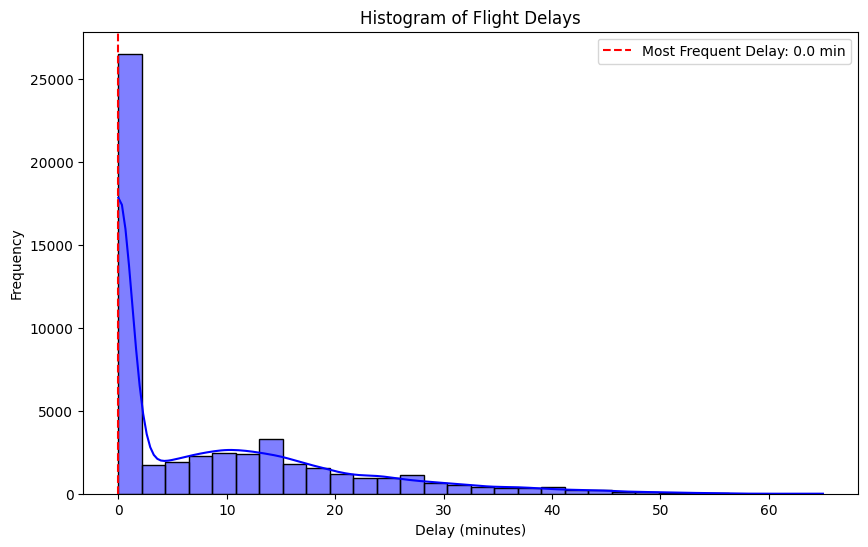

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Histogram of Delay Durations
plt.figure(figsize=(10, 6))
sns.histplot(train["Delay"], kde=True, bins=30, color='blue')
plt.title("Histogram of Flight Delays")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")

# Calculate the most frequent delay
most_frequent_delay = train["Delay"].mode()[0]

# Annotate the most frequent delay on the graph
plt.axvline(most_frequent_delay, color='red', linestyle='--', label=f'Most Frequent Delay: {most_frequent_delay} min')
plt.legend()

plt.show()


**Temporal Analysis**
Line plots or bar charts showing delays across hours, days, or months.

i. Delays by Hour of Day:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


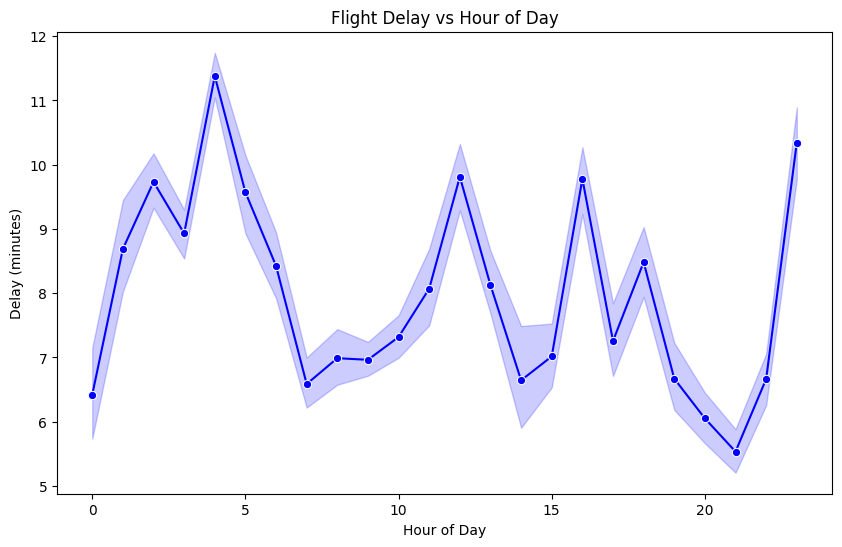

In [190]:
train['Scheduled_Hour'] = train['Scheduled Time'].dt.hour
plt.figure(figsize=(10, 6))
sns.lineplot(x="Scheduled_Hour", y="Delay", data=train, marker="o", color='blue')
plt.title("Flight Delay vs Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Delay (minutes)")
plt.show()


ii. Delays by Day of Week:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


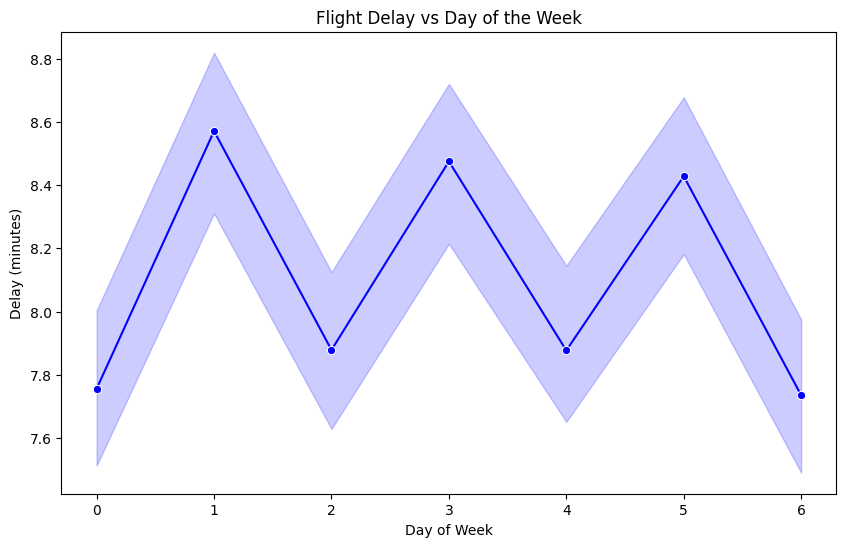

In [191]:
train['Scheduled_DayofWeek'] = train['Scheduled Time'].dt.dayofweek
plt.figure(figsize=(10, 6))
sns.lineplot(x="Scheduled_DayofWeek", y="Delay", data=train, marker="o", color='blue')
plt.title("Flight Delay vs Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Delay (minutes)")
plt.show()



iii. Delays by Month:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


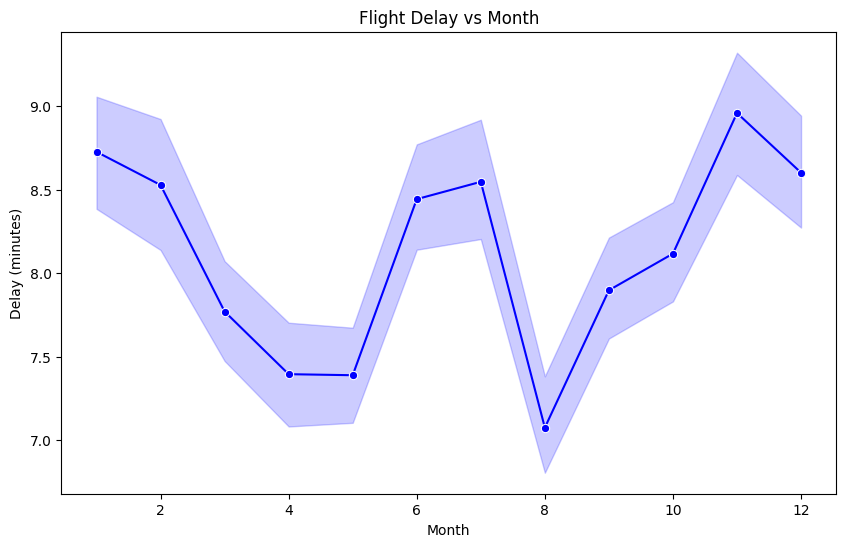

In [192]:
train['Scheduled_Month'] = train['Scheduled Time'].dt.month
plt.figure(figsize=(10, 6))
sns.lineplot(x="Scheduled_Month", y="Delay", data=train, marker="o", color='blue')
plt.title("Flight Delay vs Month")
plt.xlabel("Month")
plt.ylabel("Delay (minutes)")
plt.show()


In [193]:
# List of columns to drop
columns_to_drop = [
    "Scheduled_Hour",                 
    "Scheduled_DayofWeek",
    "Scheduled_Month"
]
train = train.drop(columns=columns_to_drop)


**Category-Wise Analysis:**
Group delays by airline, departure airport, or flight status.

i. delays by airline

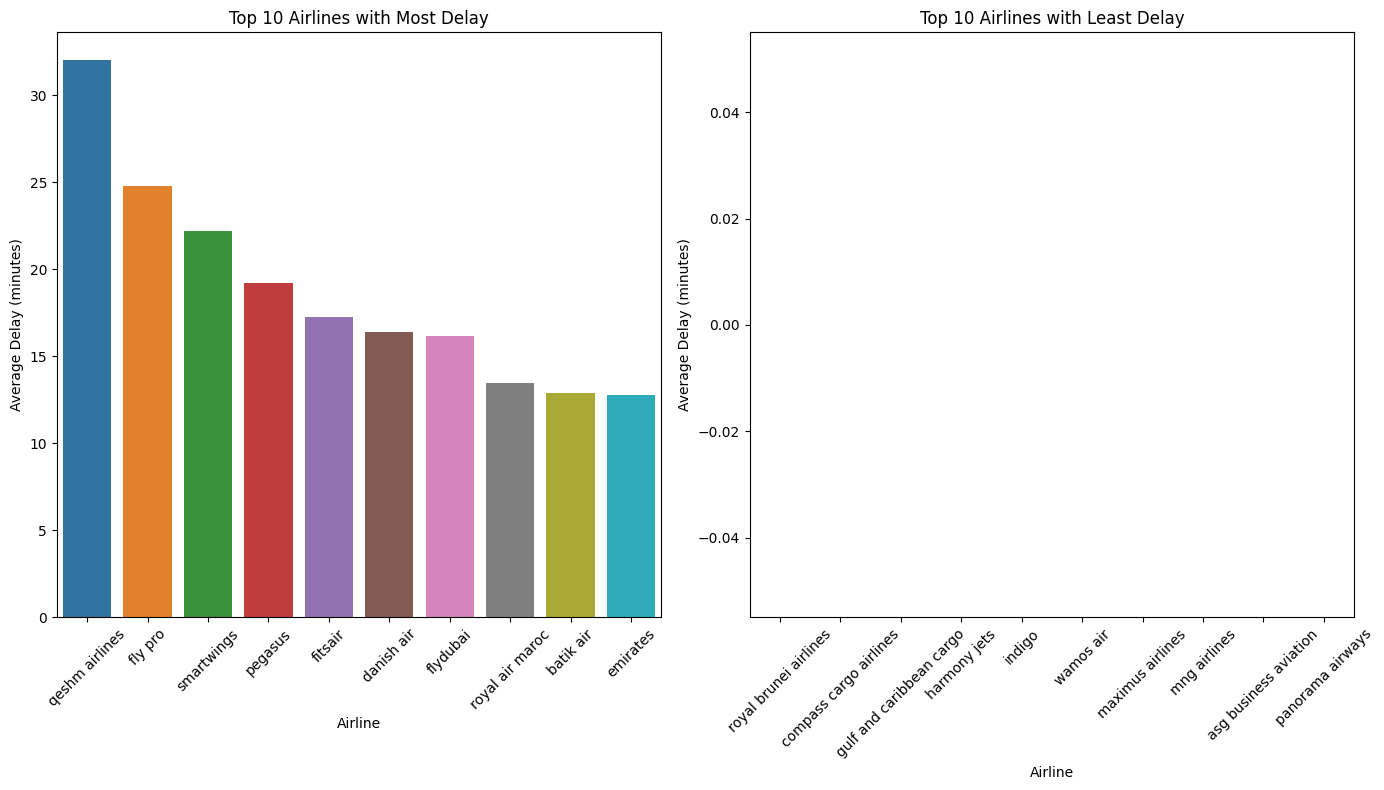

In [194]:
avg_delay_by_airline = train.groupby("Airline_Name")["Delay"].mean().reset_index()
top_10_most_delay = avg_delay_by_airline.sort_values("Delay", ascending=False).head(10)
top_10_least_delay = avg_delay_by_airline.sort_values("Delay", ascending=True).head(10)
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
sns.barplot(x="Airline_Name", y="Delay", data=top_10_most_delay)
plt.title("Top 10 Airlines with Most Delay")
plt.xlabel("Airline")
plt.ylabel("Average Delay (minutes)")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x="Airline_Name", y="Delay", data=top_10_least_delay)
plt.title("Top 10 Airlines with Least Delay")
plt.xlabel("Airline")
plt.ylabel("Average Delay (minutes)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


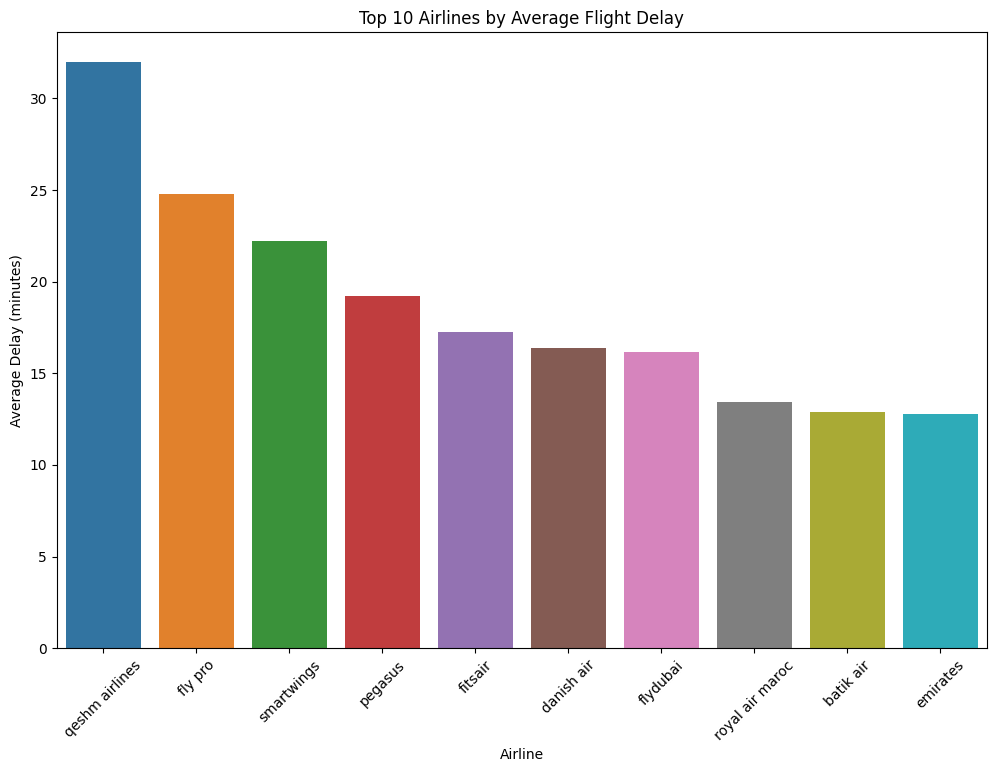

In [195]:
avg_delay_by_airline = train.groupby("Airline_Name")["Delay"].mean().reset_index()
top_n = 10  
top_airlines = avg_delay_by_airline.sort_values("Delay", ascending=False).head(top_n)
plt.figure(figsize=(12, 8))
sns.barplot(x="Airline_Name", y="Delay", data=top_airlines)  
plt.title(f"Top {top_n} Airlines by Average Flight Delay")
plt.xlabel("Airline")
plt.ylabel("Average Delay (minutes)")
plt.xticks(rotation=45)
plt.show()


ii. departure airport

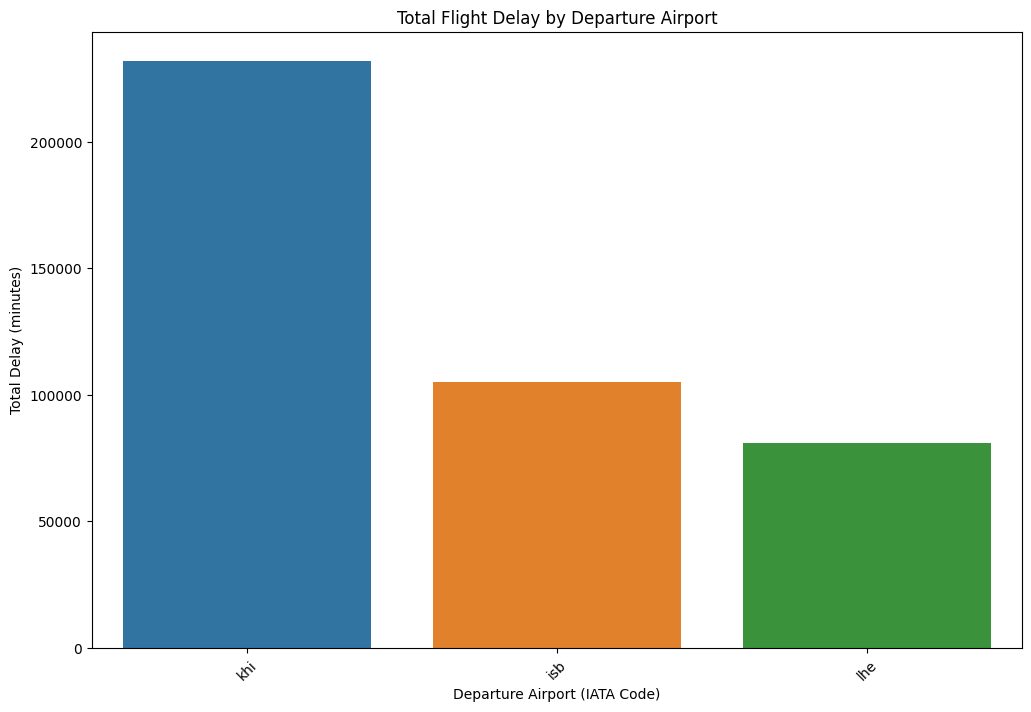

In [196]:
total_delay_by_airport = train.groupby("Departure IATA Code")["Delay"].sum().reset_index()
total_delay_by_airport = total_delay_by_airport.sort_values("Delay", ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x="Departure IATA Code", y="Delay", data=total_delay_by_airport)
plt.title("Total Flight Delay by Departure Airport")
plt.xlabel("Departure Airport (IATA Code)")
plt.ylabel("Total Delay (minutes)")
plt.xticks(rotation=45)
plt.show()


iii. flight status

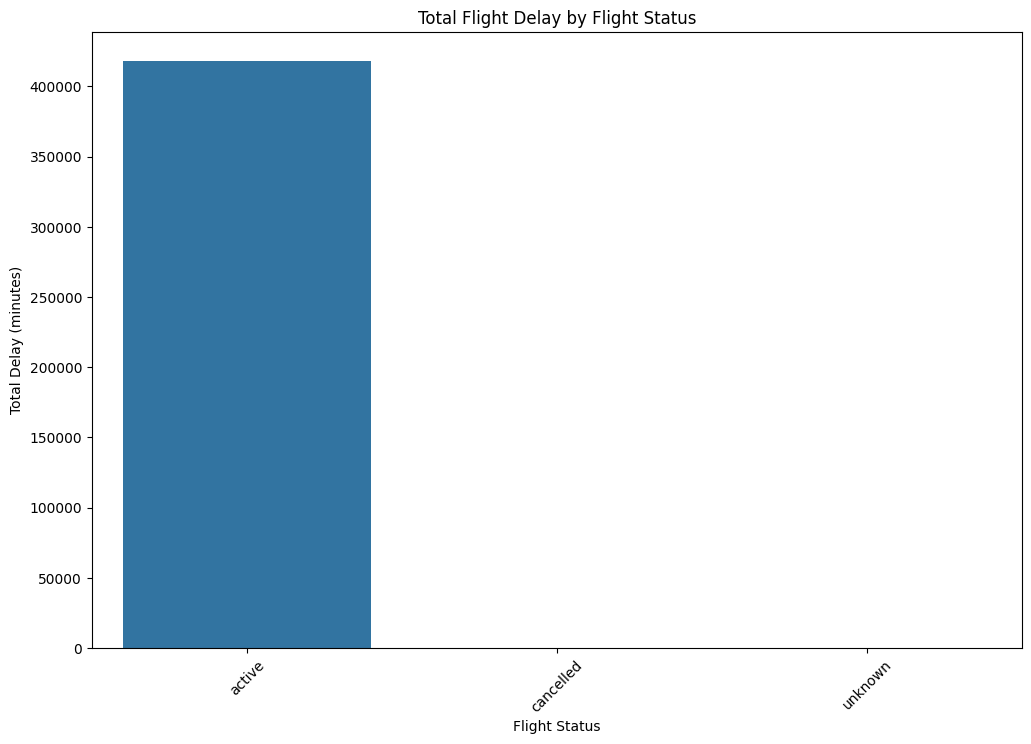

In [197]:
total_delay_by_status = train.groupby("Status")["Delay"].sum().reset_index()
total_delay_by_status = total_delay_by_status.sort_values("Delay", ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x="Status", y="Delay", data=total_delay_by_status)
plt.title("Total Flight Delay by Flight Status")
plt.xlabel("Flight Status")
plt.ylabel("Total Delay (minutes)")
plt.xticks(rotation=45)
plt.show()

# 2. Correlation Analysis
**The relationship between weather and flight data. (at least 3 different visualizations)**

In [198]:
train.columns

Index(['File Name', 'Type', 'Status', 'Departure IATA Code',
       'Departure ICAO Code', 'Scheduled Time', 'Arrival IATA Code',
       'Arrival ICAO Code', 'Arrival Estimated Time', 'Airline_Name',
       'Flight Number', 'Temperature (°F)Max', 'Temperature (°F)Avg',
       'Temperature (°F)Min', 'Dew Point (°F)Max', 'Dew Point (°F)Avg',
       'Dew Point (°F)Min', 'Humidity (%)Max', 'Humidity (%)Avg',
       'Humidity (%)Min', 'Wind Speed (mph)Max', 'Wind Speed (mph)Avg',
       'Wind Speed (mph)Min', 'Pressure (in)Max', 'Pressure (in)Avg',
       'Pressure (in)Min', 'Delay', 'Scheduled Time_Month',
       'Scheduled Time_Day', 'Scheduled Time_Hour', 'Scheduled Time_Minute',
       'Arrival Estimated Time_Month', 'Arrival Estimated Time_Day',
       'Arrival Estimated Time_Hour', 'Arrival Estimated Time_Minute'],
      dtype='object')

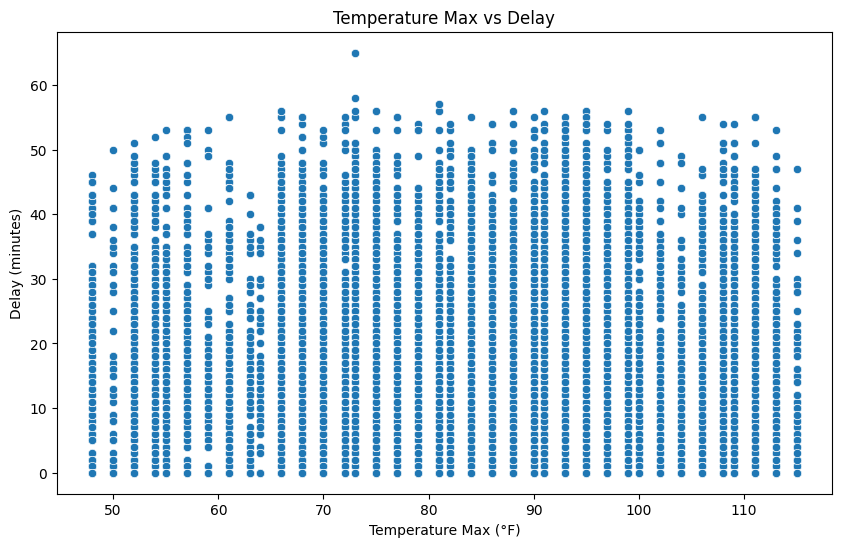

In [199]:
# Scatter plot of Temperature Max vs Delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature (°F)Max', y='Delay', data=train)
plt.title("Temperature Max vs Delay")
plt.xlabel("Temperature Max (°F)")
plt.ylabel("Delay (minutes)")
plt.show()


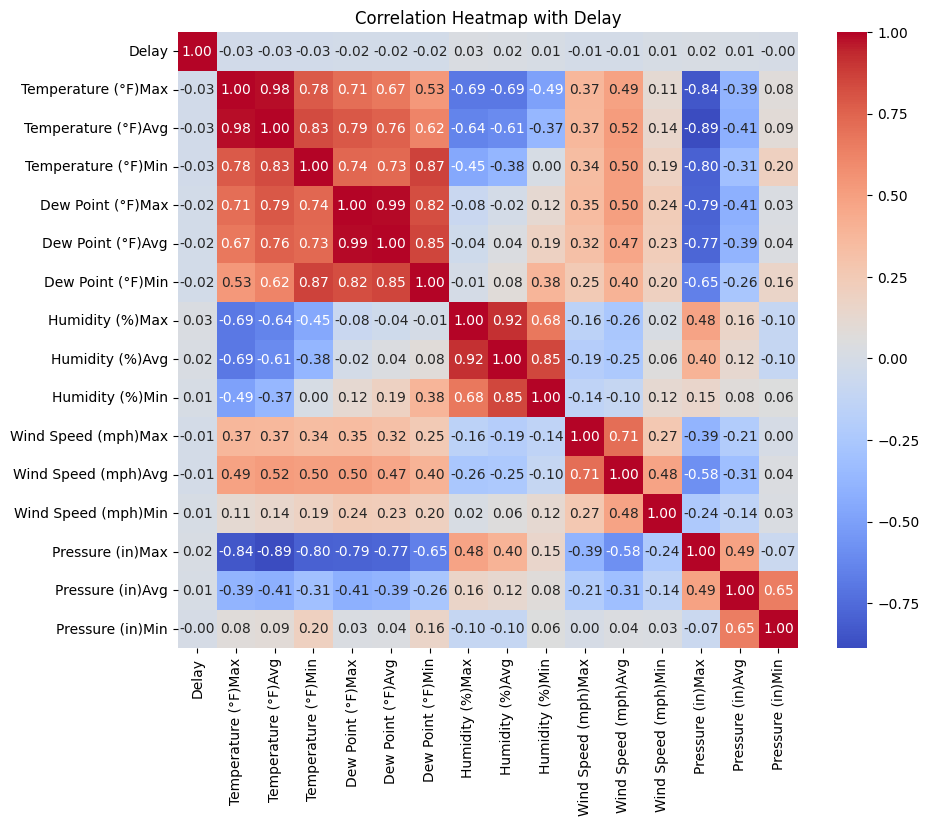

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = train[['Delay'] + [
    'Temperature (°F)Max', 'Temperature (°F)Avg', 'Temperature (°F)Min',
    'Dew Point (°F)Max', 'Dew Point (°F)Avg', 'Dew Point (°F)Min',
    'Humidity (%)Max', 'Humidity (%)Avg', 'Humidity (%)Min',
    'Wind Speed (mph)Max', 'Wind Speed (mph)Avg', 'Wind Speed (mph)Min',
    'Pressure (in)Max', 'Pressure (in)Avg', 'Pressure (in)Min']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap with Delay')
plt.show()


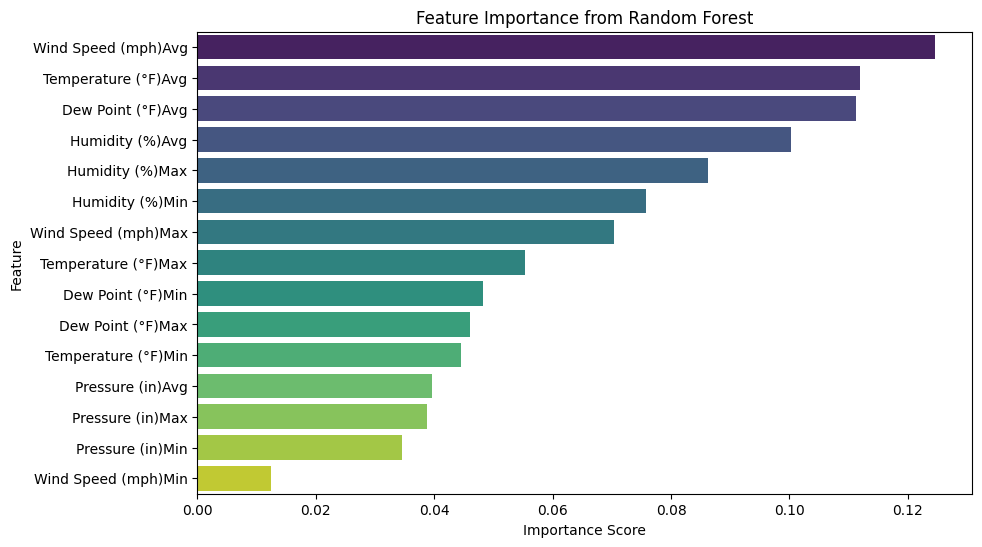

In [201]:
from sklearn.ensemble import RandomForestRegressor

features = [
    'Temperature (°F)Max', 'Temperature (°F)Avg', 'Temperature (°F)Min',
    'Dew Point (°F)Max', 'Dew Point (°F)Avg', 'Dew Point (°F)Min',
    'Humidity (%)Max', 'Humidity (%)Avg', 'Humidity (%)Min',
    'Wind Speed (mph)Max', 'Wind Speed (mph)Avg', 'Wind Speed (mph)Min',
    'Pressure (in)Max', 'Pressure (in)Avg', 'Pressure (in)Min'
]
X = train[features]
y = train['Delay']
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

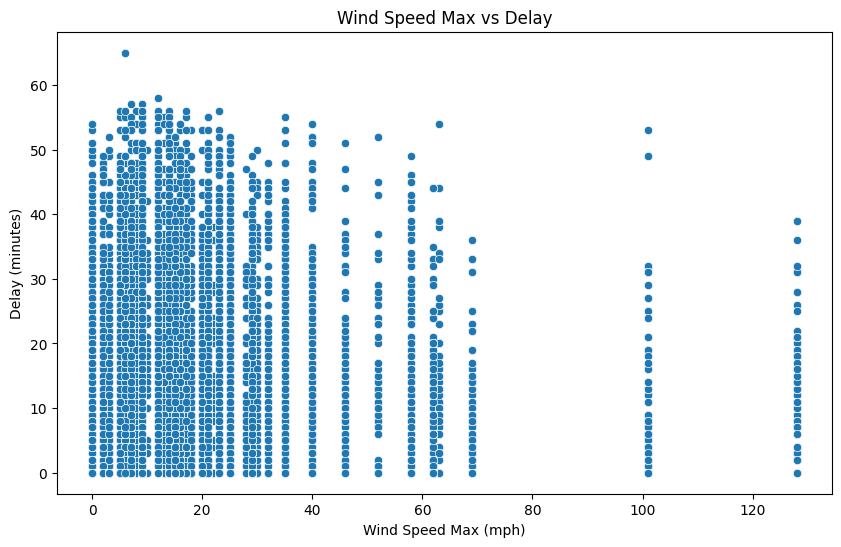

In [202]:
# Scatter plot of Wind Speed Max vs Delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Wind Speed (mph)Max', y='Delay', data=train)
plt.title("Wind Speed Max vs Delay")
plt.xlabel("Wind Speed Max (mph)")
plt.ylabel("Delay (minutes)")
plt.show()


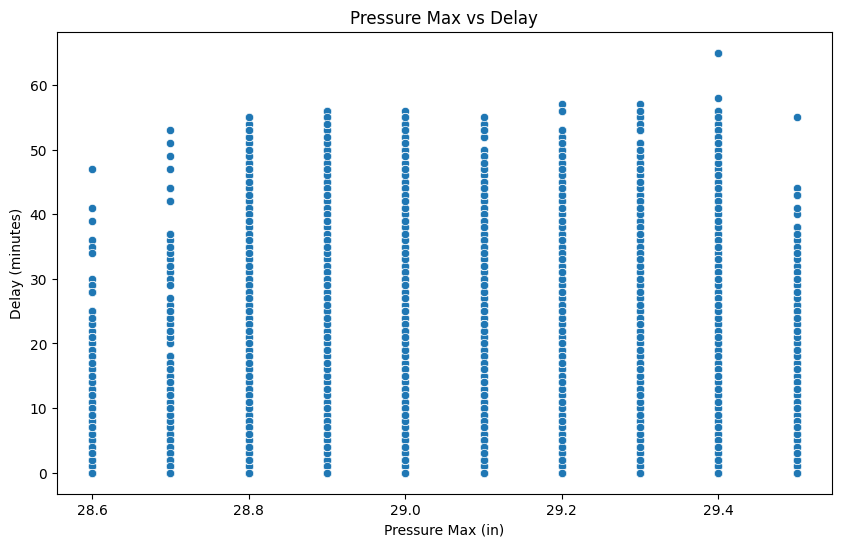

In [203]:
# Scatter plot of Pressure Max vs Delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Pressure (in)Max', y='Delay', data=train)
plt.title("Pressure Max vs Delay")
plt.xlabel("Pressure Max (in)")
plt.ylabel("Delay (minutes)")
plt.show()


# 3. Comparison
Compare delays across training and testing datasets to check for data consistency.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


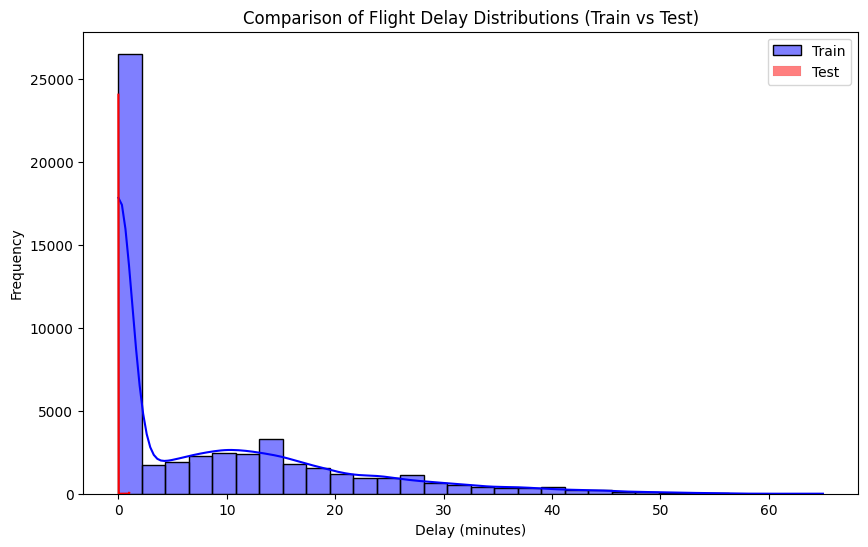

In [204]:
# Plot histograms for delay distribution in train vs test data
plt.figure(figsize=(10, 6))
sns.histplot(train["Delay"], kde=True, color='blue', label='Train', bins=30)
sns.histplot(test_for_binary["Delay"], kde=True, color='red', label='Test', bins=30)
plt.title("Comparison of Flight Delay Distributions (Train vs Test)")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# **Phase 3: Analytical and Predictive Tasks**

# **CLASSIFICATION TASK**

# **1. Binary Classification**

In [256]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def normalize(df):
    scaler = MinMaxScaler()  
    df_normalized = df.copy()  
    df_normalized[df_normalized.columns] = scaler.fit_transform(df[df.columns])
    return df_normalized

In [258]:
train.columns

Index(['File Name', 'Type', 'Status', 'Departure IATA Code',
       'Departure ICAO Code', 'Scheduled Time', 'Arrival IATA Code',
       'Arrival ICAO Code', 'Arrival Estimated Time', 'Flight Number',
       'Temperature (°F)Max', 'Temperature (°F)Avg', 'Temperature (°F)Min',
       'Dew Point (°F)Max', 'Dew Point (°F)Avg', 'Dew Point (°F)Min',
       'Humidity (%)Max', 'Humidity (%)Avg', 'Humidity (%)Min',
       'Wind Speed (mph)Max', 'Wind Speed (mph)Avg', 'Wind Speed (mph)Min',
       'Pressure (in)Max', 'Pressure (in)Avg', 'Pressure (in)Min', 'Delay',
       'Scheduled Time_Month', 'Scheduled Time_Day', 'Scheduled Time_Hour',
       'Scheduled Time_Minute', 'Arrival Estimated Time_Month',
       'Arrival Estimated Time_Day', 'Arrival Estimated Time_Hour',
       'Arrival Estimated Time_Minute'],
      dtype='object')

In [259]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_for_binary = train.copy()

test_for_binary = test.copy()

columns_to_encode = ['Status', 'Departure IATA Code', 'Departure ICAO Code', 
                     'Arrival IATA Code', 'Arrival ICAO Code']

for column in columns_to_encode:
    test_for_binary[column] = label_encoder.fit_transform(test_for_binary[column])
    train_for_binary[column] = label_encoder.fit_transform(train_for_binary[column])
train_for_binary['Delay_Label'] = train_for_binary['Delay'].apply(lambda x: 1 if x > 0 else 0) 
features = ['Temperature (°F)Avg','Dew Point (°F)Avg',
            'Humidity (%)Avg', 'Wind Speed (mph)Max', 'Wind Speed (mph)Avg',
            'Scheduled Time_Hour','Status', 'Humidity (%)Min',
            'Scheduled Time_Minute', 'Arrival Estimated Time_Hour',
            'Arrival Estimated Time_Minute',
            'Arrival IATA Code','Arrival ICAO Code']

train_for_binary[features] = normalize(train_for_binary[features])

X = train_for_binary[features]
y = train_for_binary['Delay_Label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# Training Accuracy
train_predictions = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

print(f"Training Accuracy: {accuracy_score(y_train, train_predictions)}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)}")

test_predictions = model.predict(test_for_binary[features])
test_result = pd.DataFrame({
    'ID': np.arange(1, len(test_for_binary) + 1),  
    'Predicted_Delay': test_predictions 
})

test_for_binary['Delay'] = test_result['Predicted_Delay']

Training Accuracy: 0.9996606636449572
Validation Accuracy: 0.9026660203587009


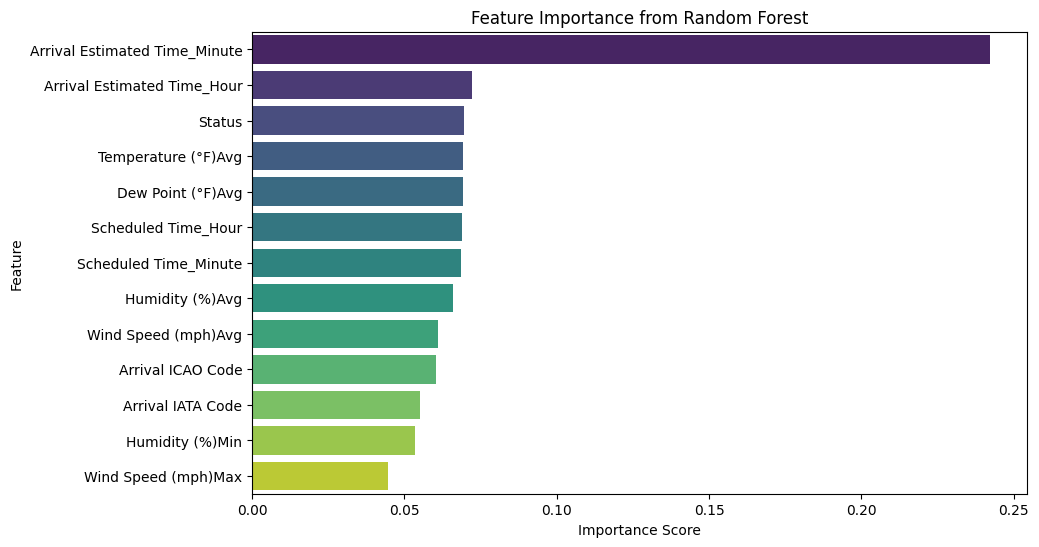

In [260]:
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4988
           1       0.90      0.91      0.91      5327

    accuracy                           0.90     10315
   macro avg       0.90      0.90      0.90     10315
weighted avg       0.90      0.90      0.90     10315

Confusion Matrix:
[[4447  541]
 [ 463 4864]]


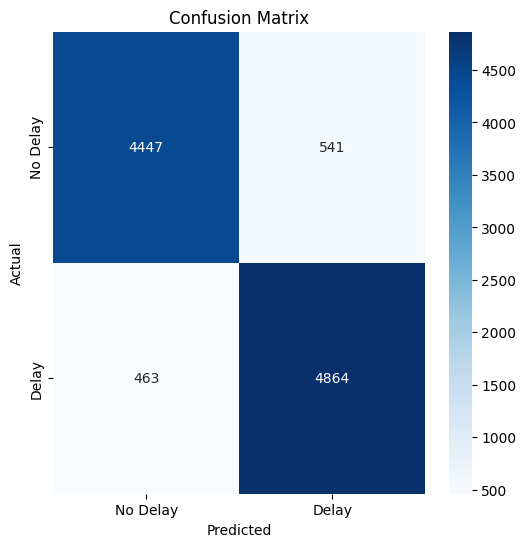

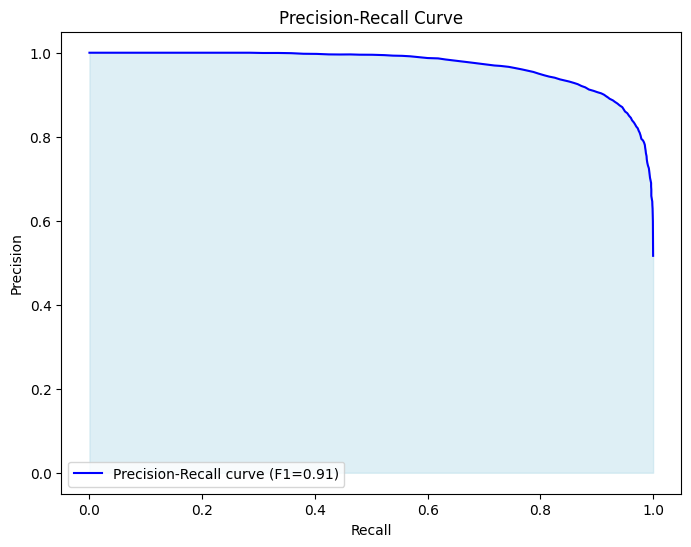

Average Precision Score: 0.9693

Class-wise Precision and Recall:
Class 0:
  Precision: 0.9057
  Recall: 0.8915
  F1-Score: 0.8986
------------------------------
Class 1:
  Precision: 0.8999
  Recall: 0.9131
  F1-Score: 0.9064
------------------------------


In [261]:
# Classification Report (precision, recall, f1-score, support)
print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the Confusion Matrix (heatmap)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision-Recall Curve and F1-Score for the positive class (Delay=1)
precision, recall, thresholds = precision_recall_curve(y_val, model.predict_proba(X_val)[:, 1])
f1 = f1_score(y_val, y_pred)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'Precision-Recall curve (F1={f1:.2f})')
plt.fill_between(recall, precision, color='lightblue', alpha=0.4)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

# Average Precision Score (AUC for Precision-Recall)
average_precision = average_precision_score(y_val, model.predict_proba(X_val)[:, 1])
print(f'Average Precision Score: {average_precision:.4f}')

# Class-wise Precision and Recall
print("\nClass-wise Precision and Recall:")
report = classification_report(y_val, y_pred, output_dict=True)
for class_label, metrics in report.items():
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Class {class_label}:")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-Score: {metrics['f1-score']:.4f}")
        print("-" * 30)



In [262]:
test_result['Predicted_Delay'] = test_result['Predicted_Delay'].apply(lambda x: 'delayed' if x == 1 else 'on-time')

In [263]:
test_result.to_csv('predicted_delay.csv', index=False) 

# **2. Multi-Class Classification**

In [264]:
train_for_multiclass = train.copy()
test_for_multiclass = test.copy()

columns_to_encode = ['Status', 'Departure IATA Code', 'Departure ICAO Code', 
                     'Arrival IATA Code', 'Arrival ICAO Code']

label_encoder = LabelEncoder()

for column in columns_to_encode:
    combined_data = pd.concat([train_for_multiclass[column], test_for_multiclass[column]], axis=0)
    label_encoder.fit(combined_data)
    
    train_for_multiclass[column] = label_encoder.transform(train_for_multiclass[column])
    test_for_multiclass[column] = label_encoder.transform(test_for_multiclass[column])

features = ['Scheduled Time_Minute', 'Temperature (°F)Avg',
            'Arrival ICAO Code', 'Arrival Estimated Time_Hour', 
 'Dew Point (°F)Avg', 'Arrival IATA Code', 'Arrival Estimated Time_Minute', 
  'Departure IATA Code', 'Status', 'Scheduled Time_Hour', 'Humidity (%)Avg', 
 'Humidity (%)Min', 'Wind Speed (mph)Max']




train_for_multiclass['Delay_Label'] = pd.cut(train_for_multiclass['Delay'], 
                                              bins=[-np.inf, 0, 45, 175, np.inf], 
                                              labels=["No Delay", "Short Delay", "Moderate Delay", "Long Delay"])

label_encoder = LabelEncoder()
train_for_multiclass['Delay_Label'] = label_encoder.fit_transform(train_for_multiclass['Delay_Label'])
scaler = StandardScaler()
train_for_multiclass[features] = scaler.fit_transform(train_for_multiclass[features])
X = train_for_multiclass[features]
y = train_for_multiclass['Delay_Label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
# Training Accuracy
train_predictions = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

print(f"Training Accuracy: {accuracy_score(y_train, train_predictions)}")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

Training Accuracy: 0.9999757616889255
Accuracy: 0.903247697527872


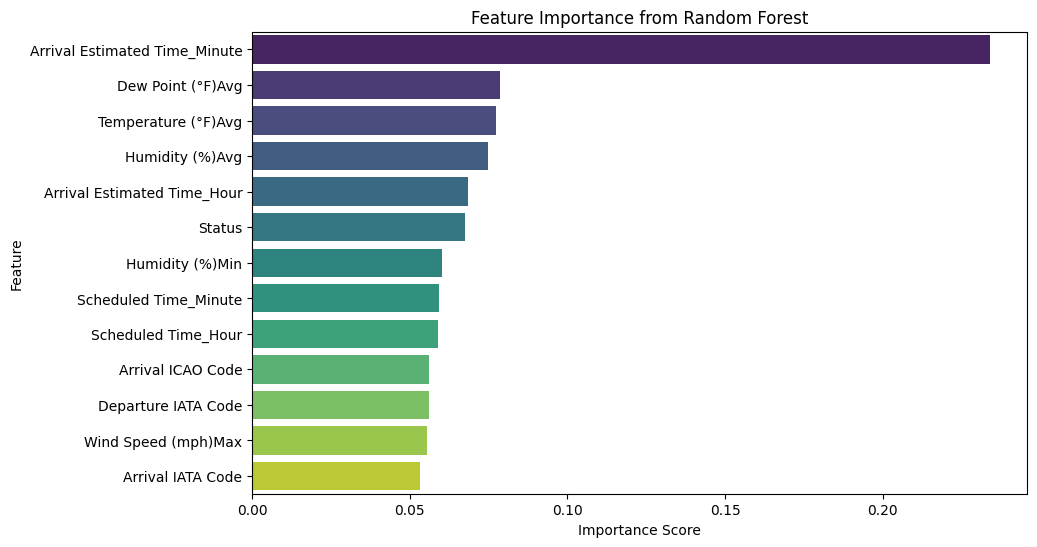

In [265]:
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show() 

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.31      0.48        80
           1       0.90      0.90      0.90      4988
           2       0.90      0.91      0.91      5247

    accuracy                           0.90     10315
   macro avg       0.94      0.71      0.76     10315
weighted avg       0.90      0.90      0.90     10315

Confusion Matrix:
[[  25   20   35]
 [   0 4499  489]
 [   0  454 4793]]


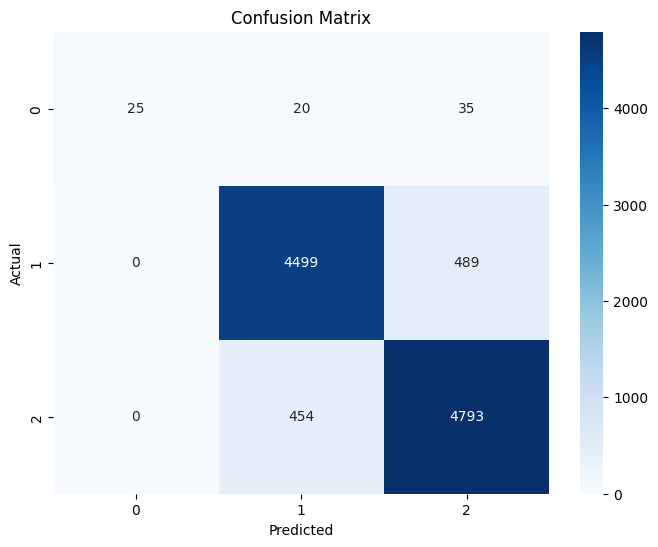

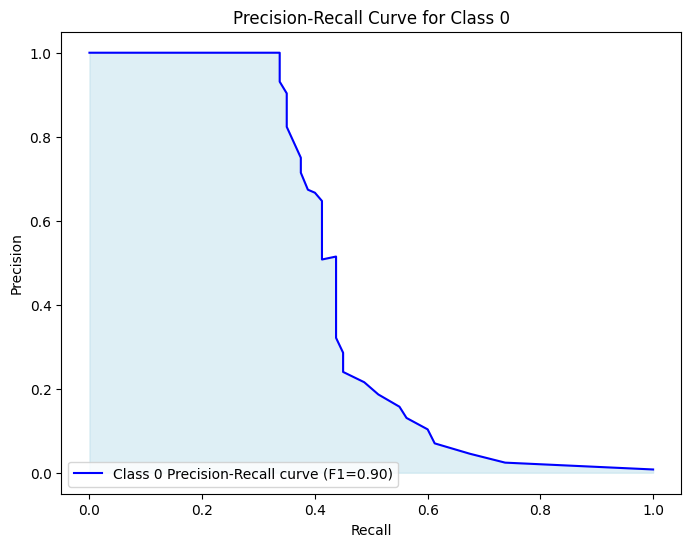

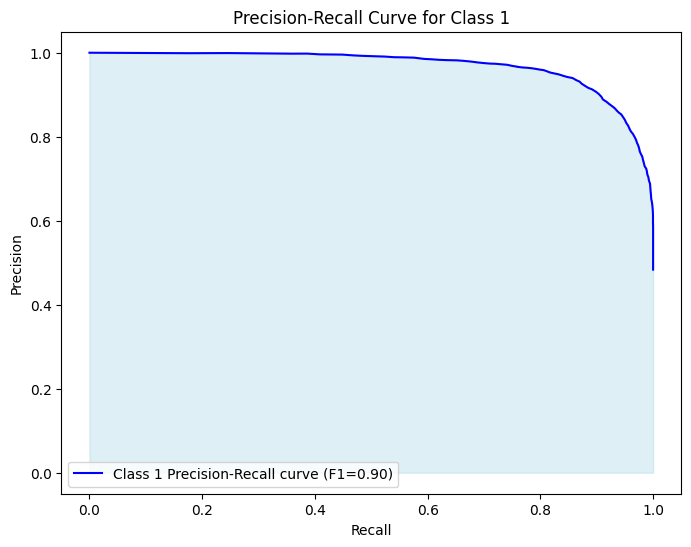

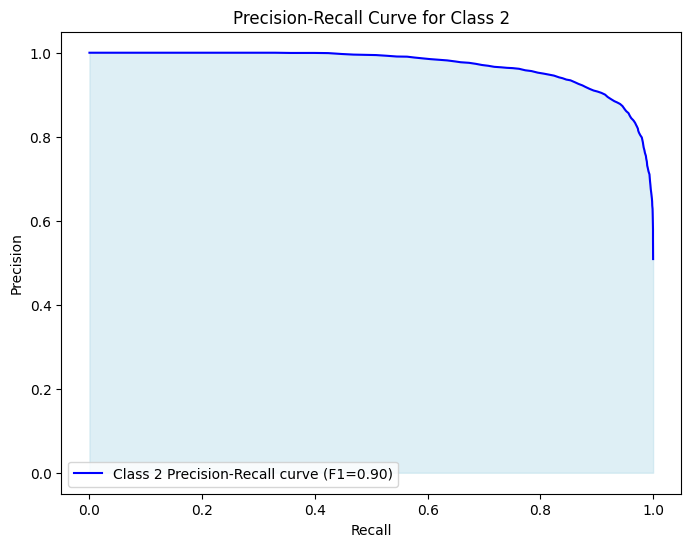

Average Precision Score (Macro-Average): 0.7924

Class-wise Precision, Recall, and F1-Score:
Class 0:
  Precision: 1.0000
  Recall: 0.3125
  F1-Score: 0.4762
------------------------------
Class 1:
  Precision: 0.9047
  Recall: 0.9020
  F1-Score: 0.9033
------------------------------
Class 2:
  Precision: 0.9014
  Recall: 0.9135
  F1-Score: 0.9074
------------------------------


In [268]:
y_pred = model.predict(X_val)
y_pred_prob = model.predict_proba(X_val)

print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

conf_matrix = confusion_matrix(y_val, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

n_classes = len(np.unique(y_val))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_val == i, y_pred_prob[:, i])
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', label=f'Class {i} Precision-Recall curve (F1={f1:.2f})')
    plt.fill_between(recall, precision, color='lightblue', alpha=0.4)
    plt.title(f'Precision-Recall Curve for Class {i}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()

average_precision_scores = []
for i in range(n_classes):
    avg_precision = average_precision_score(y_val == i, y_pred_prob[:, i])
    average_precision_scores.append(avg_precision)

macro_average_precision = np.mean(average_precision_scores)
print(f'Average Precision Score (Macro-Average): {macro_average_precision:.4f}')

print("\nClass-wise Precision, Recall, and F1-Score:")
report = classification_report(y_val, y_pred, output_dict=True)
for class_label, metrics in report.items():
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Class {class_label}:")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-Score: {metrics['f1-score']:.4f}")
        print("-" * 30)


In [269]:
test_predictions = model.predict(test_for_multiclass[features])
test_result = pd.DataFrame({
    'ID': np.arange(1, len(test_for_multiclass) + 1),  
    'Predicted_Delay': label_encoder.inverse_transform(test_predictions)  # Inverse transform the predicted labels
})
test_result

ID Predicted_Delay
0          1        No Delay
1          2        No Delay
2          3        No Delay
3          4        No Delay
4          5        No Delay
...      ...             ...
12909  12910        No Delay
12910  12911        No Delay
12911  12912        No Delay
12912  12913        No Delay
12913  12914        No Delay

[12914 rows x 2 columns]

In [270]:
test_result.to_csv('predicted_delay_multiclass.csv', index=False) 

# **Regression Analysis**

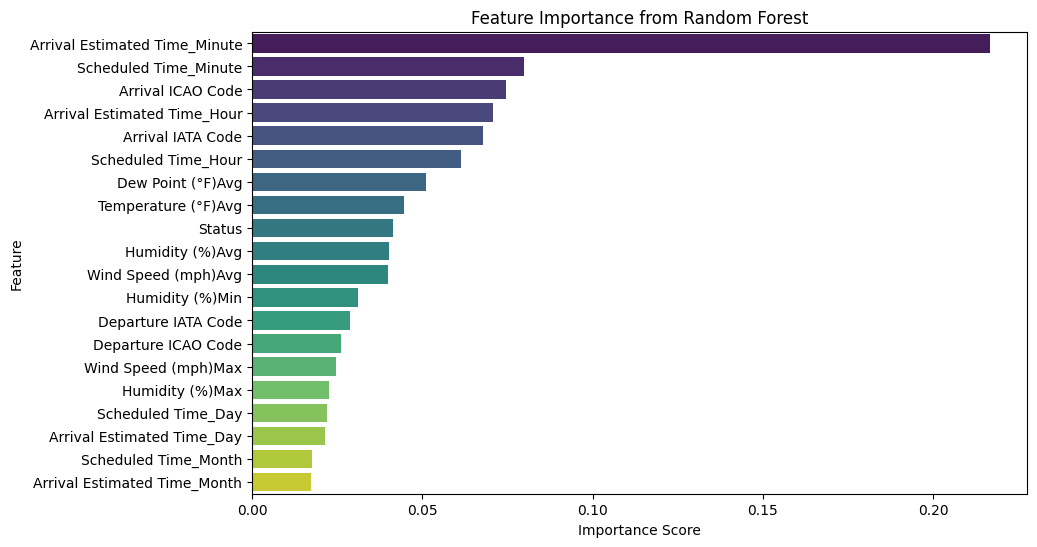

In [273]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
test_for_regressor = test.copy()
train_for_regressor = train.copy()
columns_to_encode = ['Status', 'Departure IATA Code', 'Departure ICAO Code', 
                     'Arrival IATA Code', 'Arrival ICAO Code']

for column in columns_to_encode:
    test_for_regressor[column] = label_encoder.fit_transform(test_for_regressor[column])
    train_for_regressor[column] = label_encoder.fit_transform(train_for_regressor[column])
features = ['Status', 'Departure IATA Code', 'Departure ICAO Code', 
            'Arrival IATA Code', 'Arrival ICAO Code', 'Temperature (°F)Avg',
            'Dew Point (°F)Avg', 'Humidity (%)Max', 'Humidity (%)Avg', 'Humidity (%)Min',
            'Wind Speed (mph)Max', 'Wind Speed (mph)Avg', 
            'Scheduled Time_Month', 'Scheduled Time_Day', 'Scheduled Time_Hour',
            'Scheduled Time_Minute', 'Arrival Estimated Time_Month', 'Arrival Estimated Time_Day',
            'Arrival Estimated Time_Hour', 'Arrival Estimated Time_Minute']
train_for_regressor[features] = train_for_regressor[features].fillna(train_for_regressor[features].mean())
y = train_for_regressor['Delay']
print(y)
X = train_for_regressor[features]
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X, y) 
importances = regressor.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

0        16.0
1         0.0
2         1.0
3         0.0
4        11.0
         ... 
51567     0.0
51568     0.0
51569     0.0
51570     0.0
51571     7.0
Name: Delay, Length: 51572, dtype: float64
Cross-validated MAE: 4.880192076265683
Mean Absolute Error (MAE): 1.1331645383430655
Root Mean Squared Error (RMSE): 2.2881396000924323


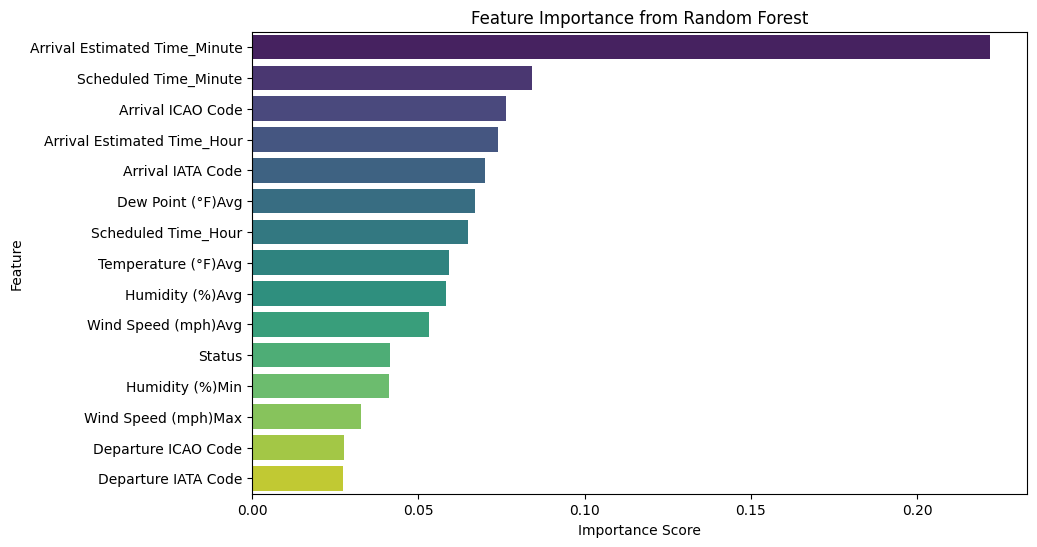

In [277]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
test_for_regressor = test.copy()
train_for_regressor = train.copy()
columns_to_encode = ['Status', 'Departure IATA Code', 'Departure ICAO Code', 
                     'Arrival IATA Code', 'Arrival ICAO Code']

for column in columns_to_encode:
    test_for_regressor[column] = label_encoder.fit_transform(test_for_regressor[column])
    train_for_regressor[column] = label_encoder.fit_transform(train_for_regressor[column])
features = ['Status', 'Departure IATA Code', 'Departure ICAO Code', 
            'Arrival IATA Code', 'Arrival ICAO Code', 'Temperature (°F)Avg',
            'Dew Point (°F)Avg', 'Humidity (%)Avg', 'Humidity (%)Min',
            'Wind Speed (mph)Max', 'Wind Speed (mph)Avg', 
            'Scheduled Time_Hour', 'Scheduled Time_Minute',
            'Arrival Estimated Time_Hour', 'Arrival Estimated Time_Minute']
train_for_regressor[features] = train_for_regressor[features].fillna(train_for_regressor[features].mean())
y = train_for_regressor['Delay']
print(y)
X = train_for_regressor[features]
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
cv_scores = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_absolute_error')
regressor.fit(X, y) 
y_pred = regressor.predict(X)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Cross-validated MAE: {-cv_scores.mean()}") 
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
importances = regressor.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [278]:
y

0        16.0
1         0.0
2         1.0
3         0.0
4        11.0
         ... 
51567     0.0
51568     0.0
51569     0.0
51570     0.0
51571     7.0
Name: Delay, Length: 51572, dtype: float64

In [279]:
test_predictions = regressor.predict(test_for_multiclass[features])
test_result = pd.DataFrame({
    'ID': np.arange(1, len(test_for_multiclass) + 1),  
    'Predicted_Delay': test_predictions
})


In [280]:
test_result

ID  Predicted_Delay
0          1             8.79
1          2             7.13
2          3             7.32
3          4             8.48
4          5             6.75
...      ...              ...
12909  12910            10.04
12910  12911             3.29
12911  12912            12.74
12912  12913             7.46
12913  12914             5.52

[12914 rows x 2 columns]

In [281]:
test_result.to_csv('predicted_delay_regression.csv', index=False) 

# **Phase 4: Model Optimization and Evaluation**

In [300]:
train_for_binary = train.copy()
test_for_binary = test.copy()
n_estimators_values = [50, 100, 150, 200] 
max_depth_values = [10] 
min_samples_split_values = [2, 5]  
best_model = None
best_params = None
best_accuracy = 0
label_encoder = LabelEncoder()
train_for_binary = train.copy()

test_for_binary = test.copy()

columns_to_encode = ['Status', 'Departure IATA Code', 'Departure ICAO Code', 
                     'Arrival IATA Code', 'Arrival ICAO Code']

for column in columns_to_encode:
    test_for_binary[column] = label_encoder.fit_transform(test_for_binary[column])
    train_for_binary[column] = label_encoder.fit_transform(train_for_binary[column])
train_for_binary['Delay_Label'] = train_for_binary['Delay'].apply(lambda x: 1 if x > 0 else 0) 
features = ['Temperature (°F)Avg','Dew Point (°F)Avg',
            'Humidity (%)Avg', 'Wind Speed (mph)Max', 'Wind Speed (mph)Avg',
            'Scheduled Time_Hour','Status', 'Humidity (%)Min',
            'Scheduled Time_Minute', 'Arrival Estimated Time_Hour',
            'Arrival Estimated Time_Minute',
            'Arrival IATA Code','Arrival ICAO Code']

train_for_binary[features] = normalize(train_for_binary[features])

X = train_for_binary[features]
y = train_for_binary['Delay_Label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                random_state=42
            )
            
            model.fit(X_train, y_train)
            
            train_predictions = model.predict(X_train)
            y_pred = model.predict(X_val)
            train_accuracy = accuracy_score(y_train, train_predictions)
            validation_accuracy = accuracy_score(y_val, y_pred)
            
            print(f"n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}")
            print(f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}")
            
            if validation_accuracy > best_accuracy:
                best_accuracy = validation_accuracy
                best_model = model
                best_params = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split
                }

print("\nBest Hyperparameters:")
print(best_params)
print(f"Best Model Validation Accuracy: {best_accuracy:.4f}")


n_estimators=50, max_depth=10, min_samples_split=2
Training Accuracy: 0.9996, Validation Accuracy: 0.9002
n_estimators=50, max_depth=10, min_samples_split=5
Training Accuracy: 0.9996, Validation Accuracy: 0.9002
n_estimators=100, max_depth=10, min_samples_split=2
Training Accuracy: 0.9997, Validation Accuracy: 0.9027
n_estimators=100, max_depth=10, min_samples_split=5
Training Accuracy: 0.9997, Validation Accuracy: 0.9027
n_estimators=150, max_depth=10, min_samples_split=2
Training Accuracy: 0.9997, Validation Accuracy: 0.8997
n_estimators=150, max_depth=10, min_samples_split=5
Training Accuracy: 0.9997, Validation Accuracy: 0.8997
n_estimators=200, max_depth=10, min_samples_split=2
Training Accuracy: 0.9997, Validation Accuracy: 0.9003
n_estimators=200, max_depth=10, min_samples_split=5
Training Accuracy: 0.9997, Validation Accuracy: 0.9003

Best Hyperparameters:
{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}
Best Model Validation Accuracy: 0.9027


In [301]:
train_for_multiclass = train.copy()
test_for_multiclass = test.copy()

columns_to_encode = ['Status', 'Departure IATA Code', 'Departure ICAO Code', 
                     'Arrival IATA Code', 'Arrival ICAO Code']

label_encoder = LabelEncoder()

for column in columns_to_encode:
    combined_data = pd.concat([train_for_multiclass[column], test_for_multiclass[column]], axis=0)
    label_encoder.fit(combined_data)
    
    train_for_multiclass[column] = label_encoder.transform(train_for_multiclass[column])
    test_for_multiclass[column] = label_encoder.transform(test_for_multiclass[column])

features = ['Scheduled Time_Minute', 'Temperature (°F)Avg',
            'Arrival ICAO Code', 'Arrival Estimated Time_Hour', 
 'Dew Point (°F)Avg', 'Arrival IATA Code', 'Arrival Estimated Time_Minute', 
  'Departure IATA Code', 'Status', 'Scheduled Time_Hour', 'Humidity (%)Avg', 
 'Humidity (%)Min', 'Wind Speed (mph)Max']




train_for_multiclass['Delay_Label'] = pd.cut(train_for_multiclass['Delay'], 
                                              bins=[-np.inf, 0, 45, 175, np.inf], 
                                              labels=["No Delay", "Short Delay", "Moderate Delay", "Long Delay"])

label_encoder = LabelEncoder()
train_for_multiclass['Delay_Label'] = label_encoder.fit_transform(train_for_multiclass['Delay_Label'])
scaler = StandardScaler()
train_for_multiclass[features] = scaler.fit_transform(train_for_multiclass[features])
X = train_for_multiclass[features]
y = train_for_multiclass['Delay_Label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                random_state=42
            )
            
            model.fit(X_train, y_train)
            
            train_predictions = model.predict(X_train)
            y_pred = model.predict(X_val)
            train_accuracy = accuracy_score(y_train, train_predictions)
            validation_accuracy = accuracy_score(y_val, y_pred)
            
            print(f"n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}")
            print(f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}")
            
            if validation_accuracy > best_accuracy:
                best_accuracy = validation_accuracy
                best_model = model
                best_params = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split
                }

print("\nBest Hyperparameters:")
print(best_params)
print(f"Best Model Validation Accuracy: {best_accuracy:.4f}")


n_estimators=50, max_depth=10, min_samples_split=2
Training Accuracy: 0.9999, Validation Accuracy: 0.9009
n_estimators=50, max_depth=10, min_samples_split=5
Training Accuracy: 0.9999, Validation Accuracy: 0.9009
n_estimators=100, max_depth=10, min_samples_split=2
Training Accuracy: 1.0000, Validation Accuracy: 0.9032
n_estimators=100, max_depth=10, min_samples_split=5
Training Accuracy: 1.0000, Validation Accuracy: 0.9032
n_estimators=150, max_depth=10, min_samples_split=2
Training Accuracy: 1.0000, Validation Accuracy: 0.9029
n_estimators=150, max_depth=10, min_samples_split=5
Training Accuracy: 1.0000, Validation Accuracy: 0.9029
n_estimators=200, max_depth=10, min_samples_split=2
Training Accuracy: 1.0000, Validation Accuracy: 0.9027
n_estimators=200, max_depth=10, min_samples_split=5
Training Accuracy: 1.0000, Validation Accuracy: 0.9027

Best Hyperparameters:
{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}
Best Model Validation Accuracy: 0.9032


# **Phase 5: Model Testing:**

## **Binary**

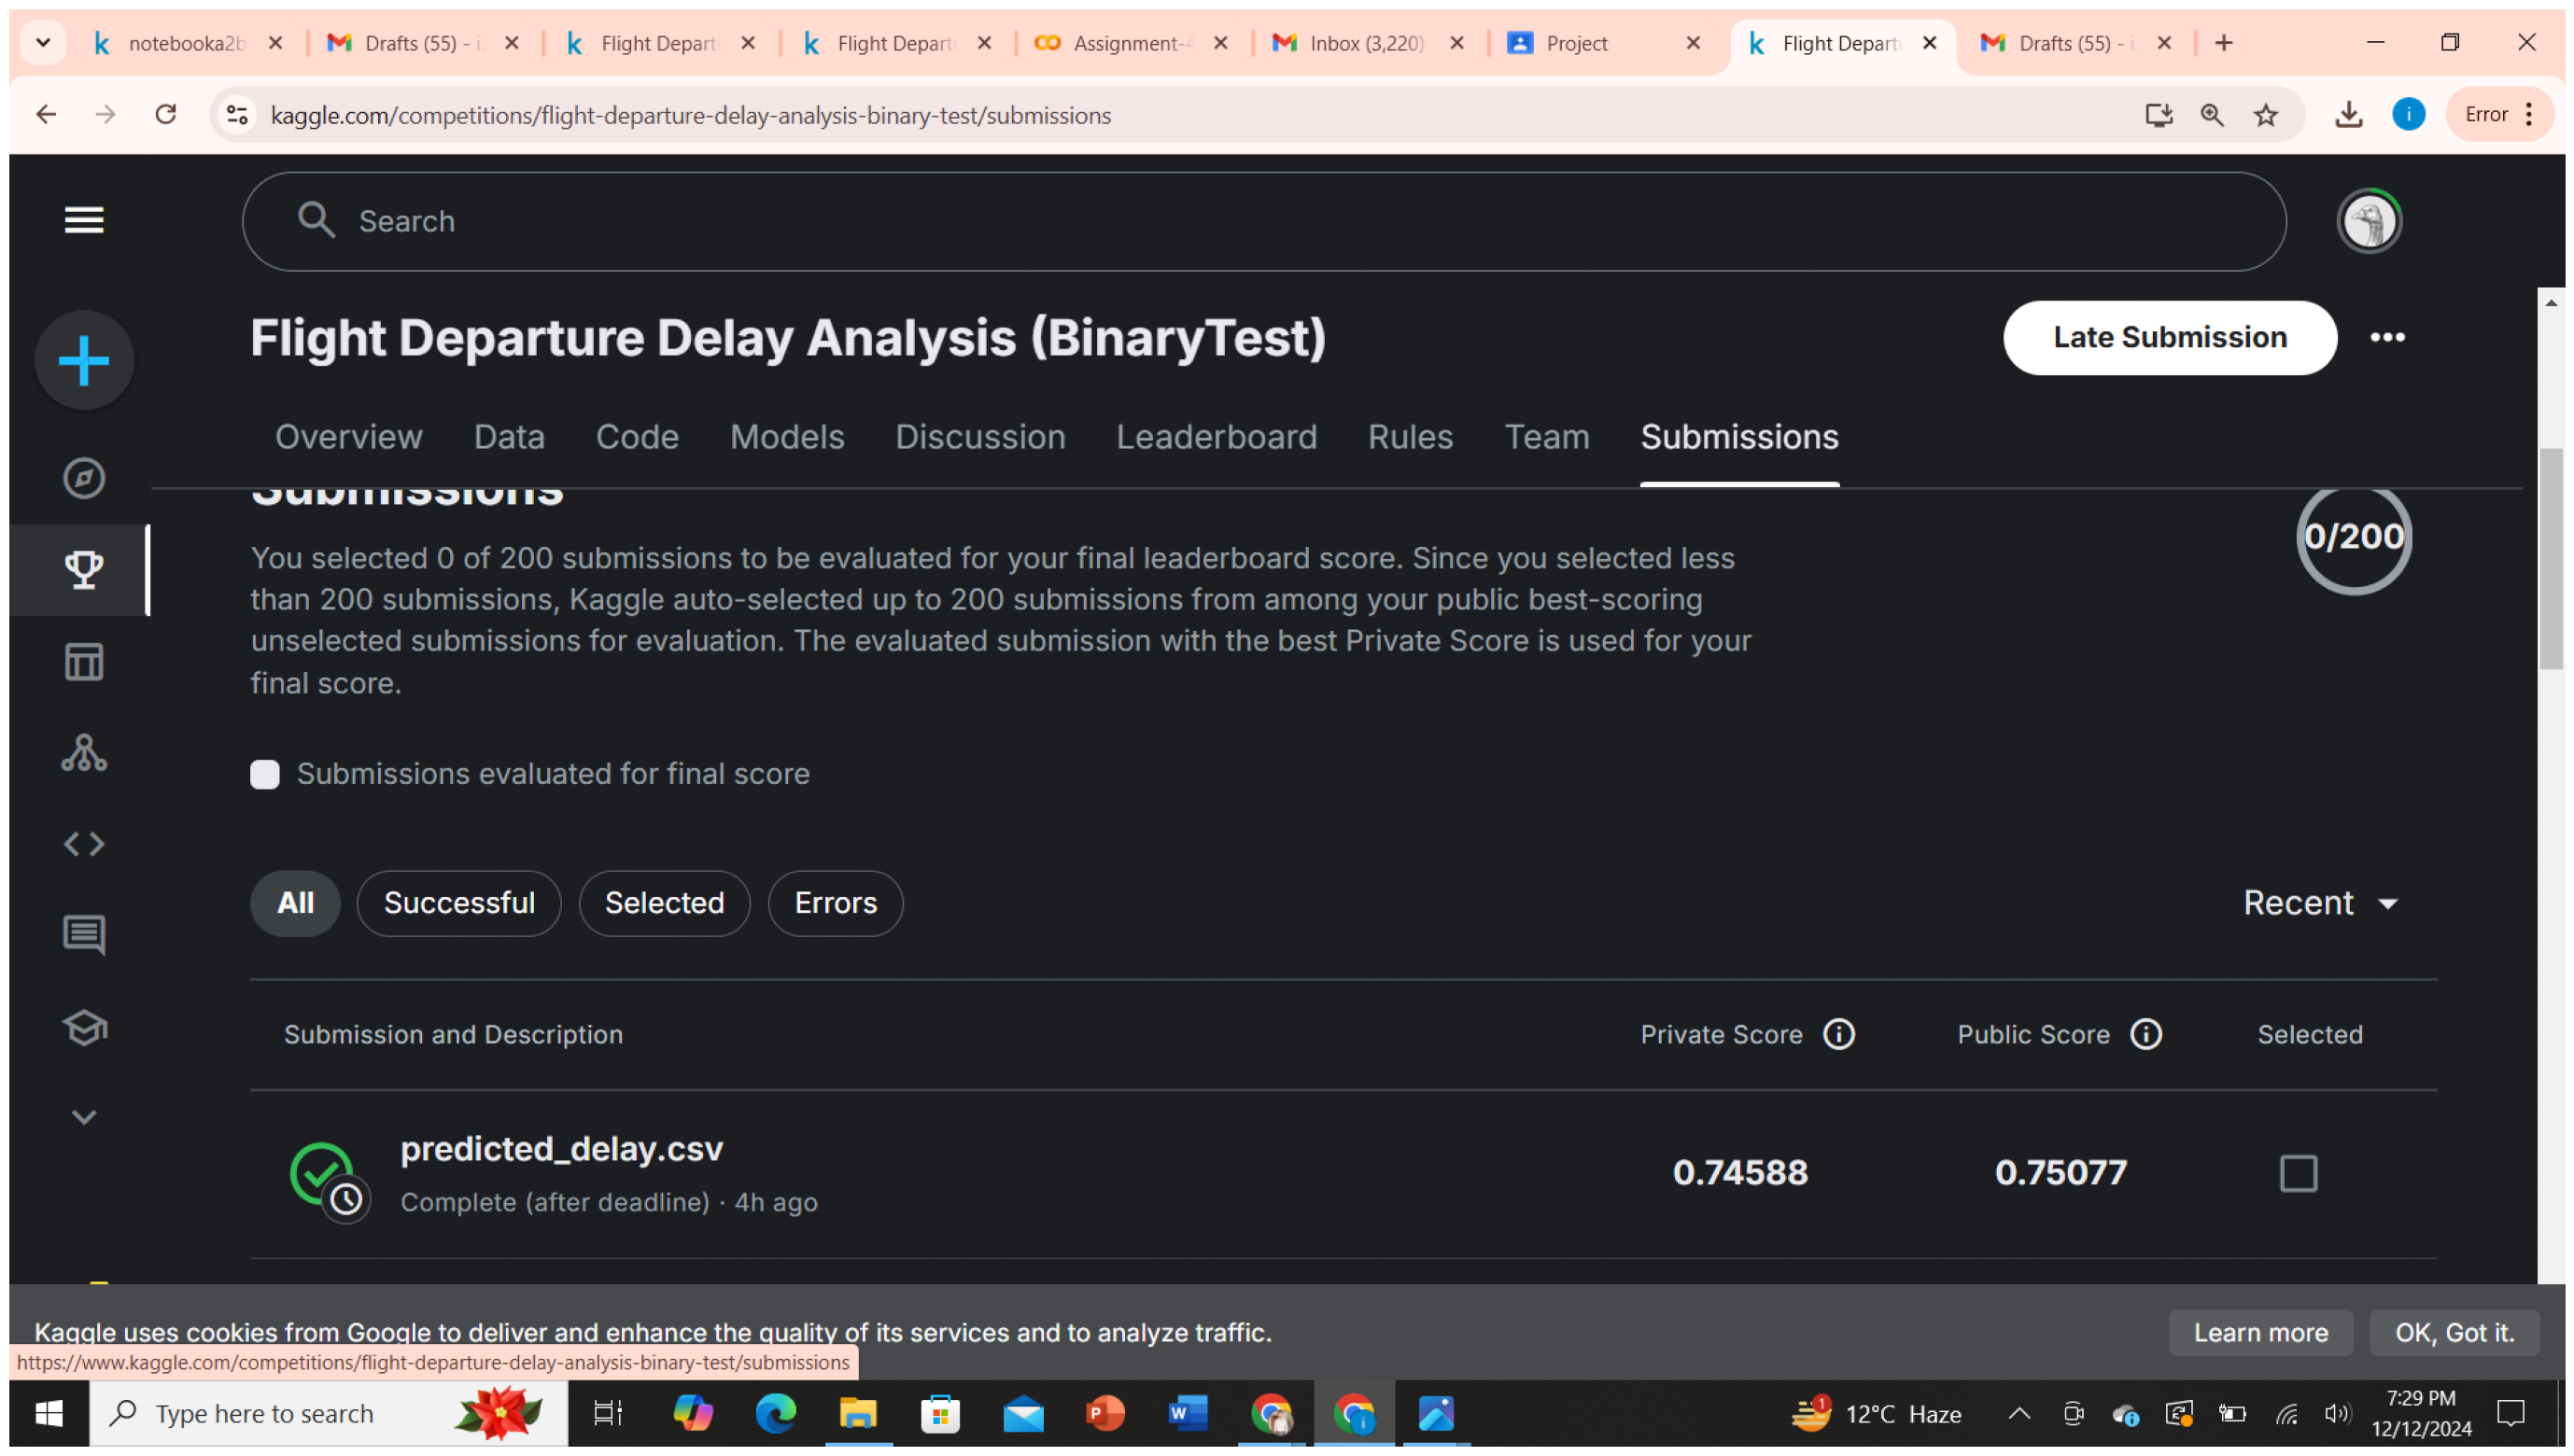

In [294]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/kaggle/input/kaggleresult/Screenshot (8).png')
plt.figure(figsize=(40, 20)) 
plt.imshow(img)
plt.axis('off') 
plt.show()


## **Multi**

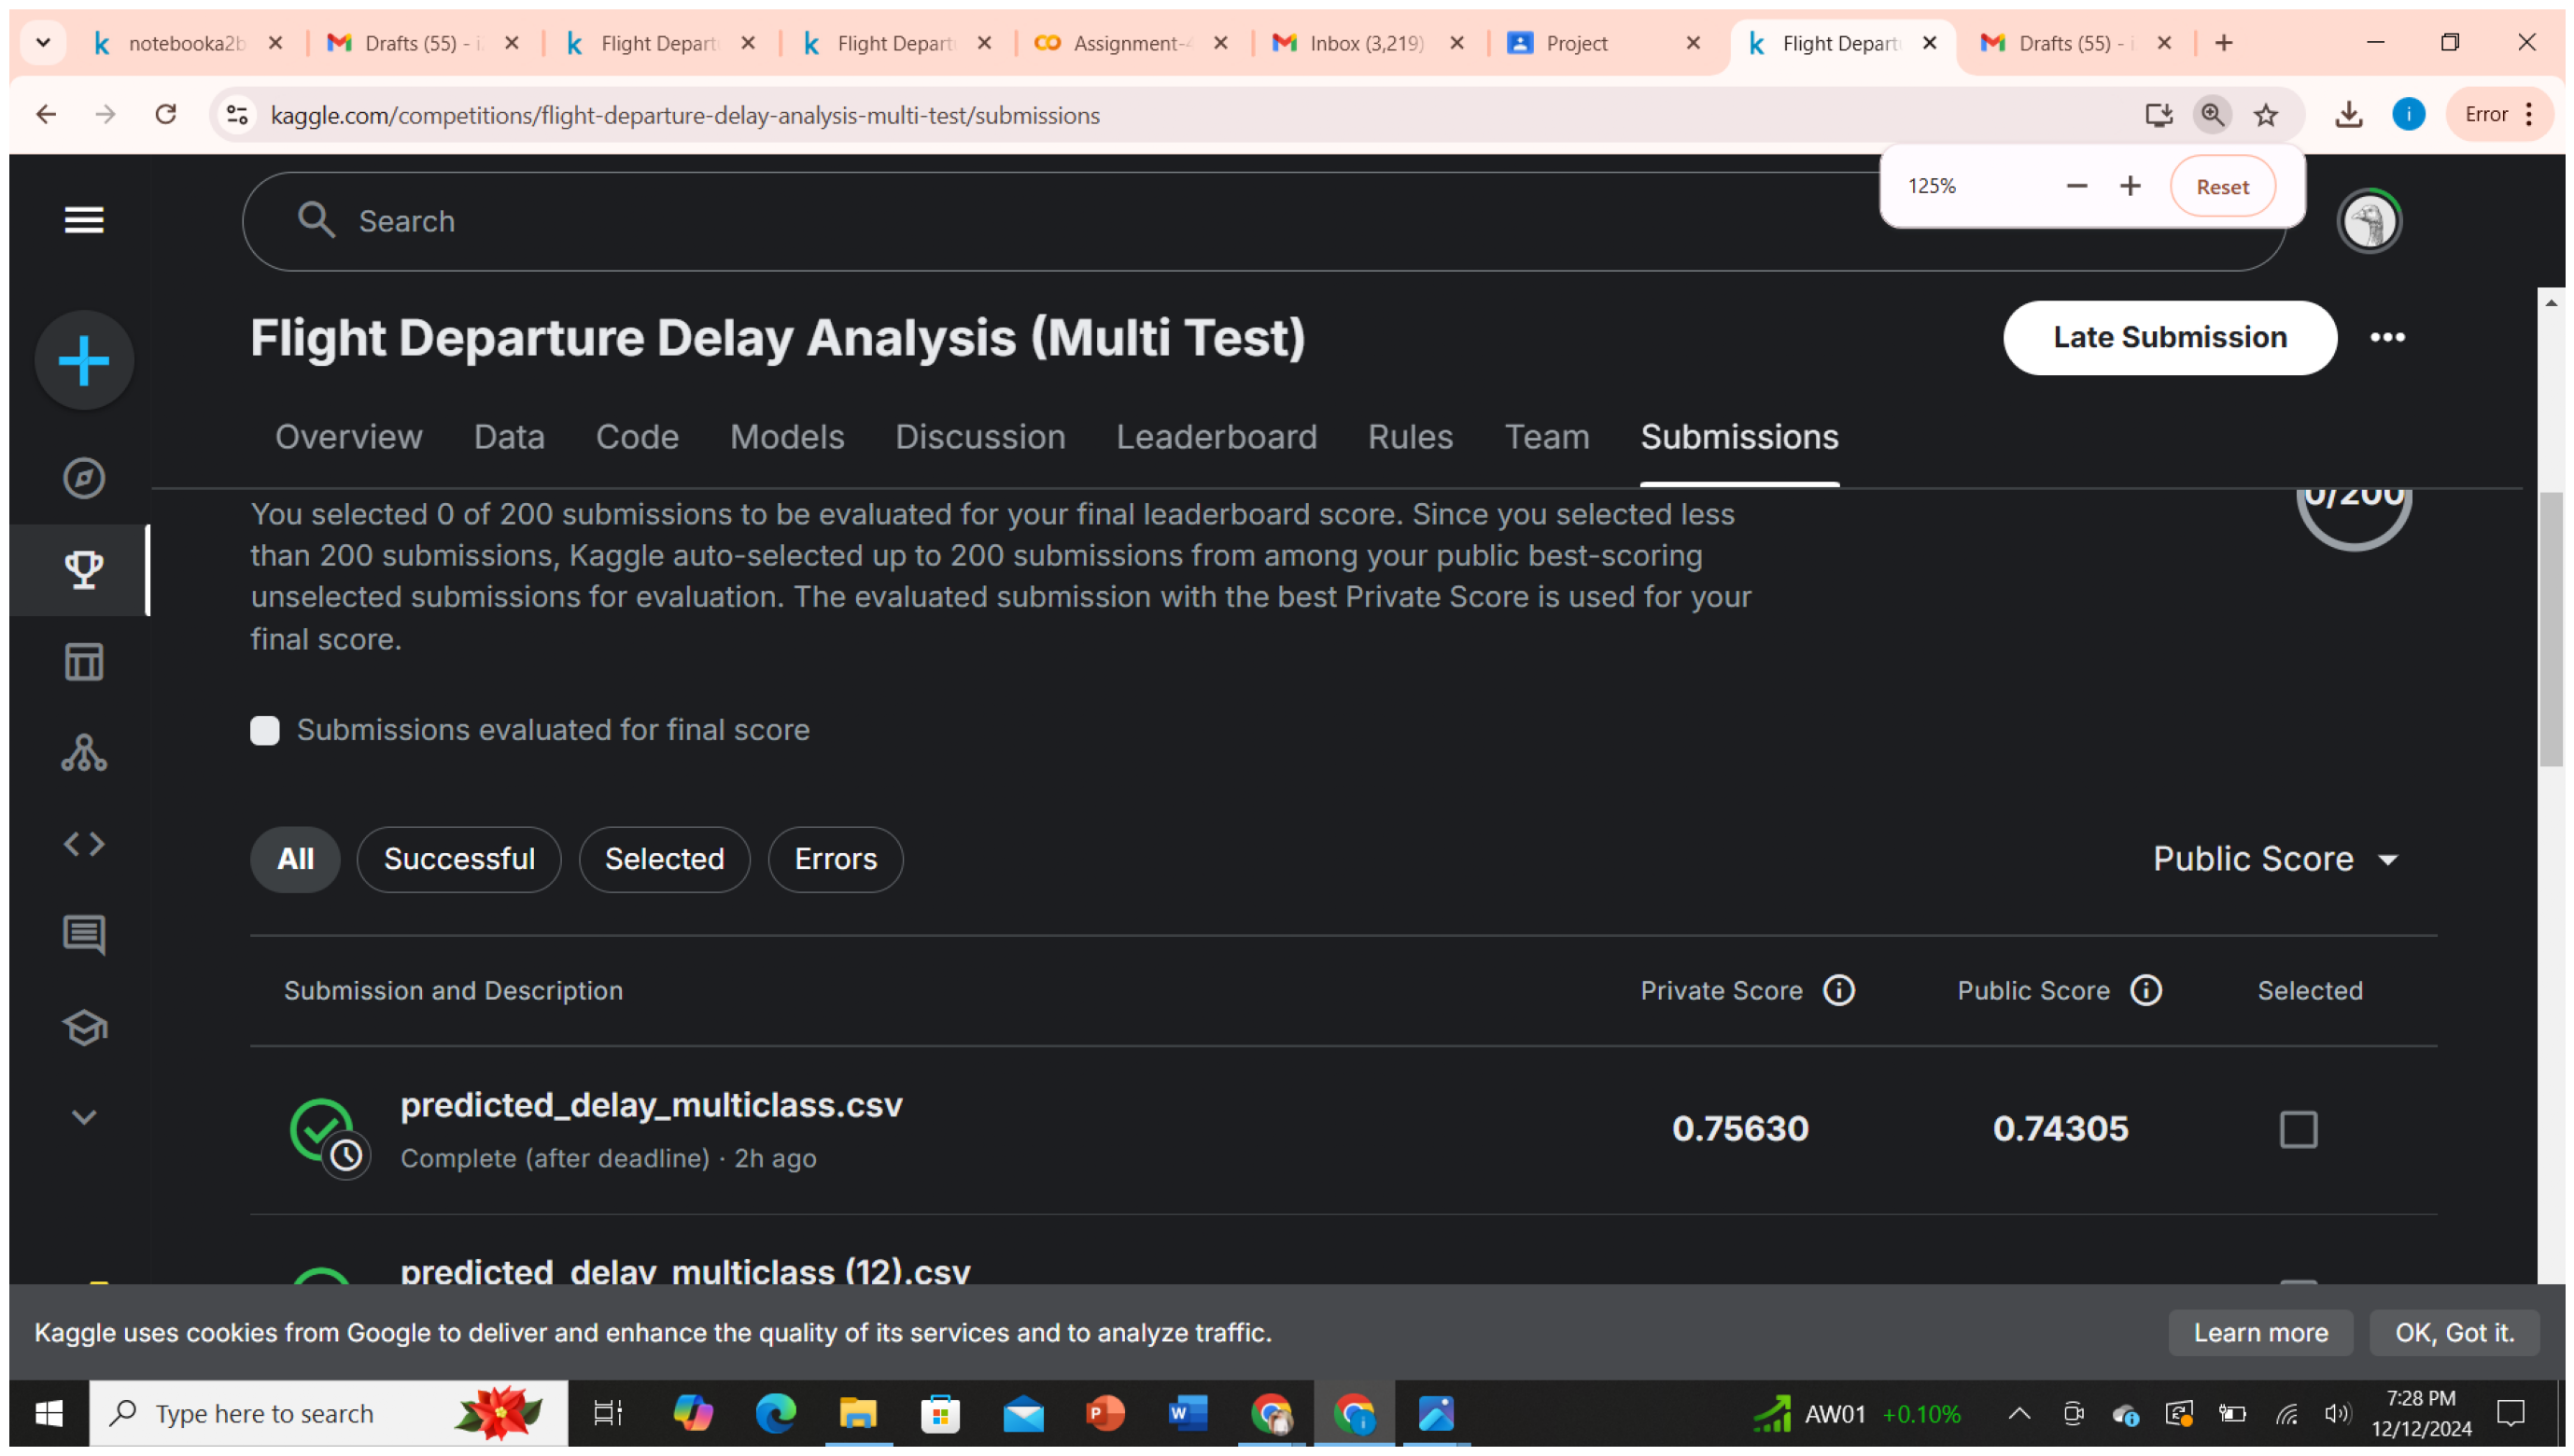

In [295]:
img = mpimg.imread('/kaggle/input/kaggleresult/Screenshot (7).png')
plt.figure(figsize=(40, 20)) 
plt.imshow(img)
plt.axis('off') 
plt.show()

## **Regression**

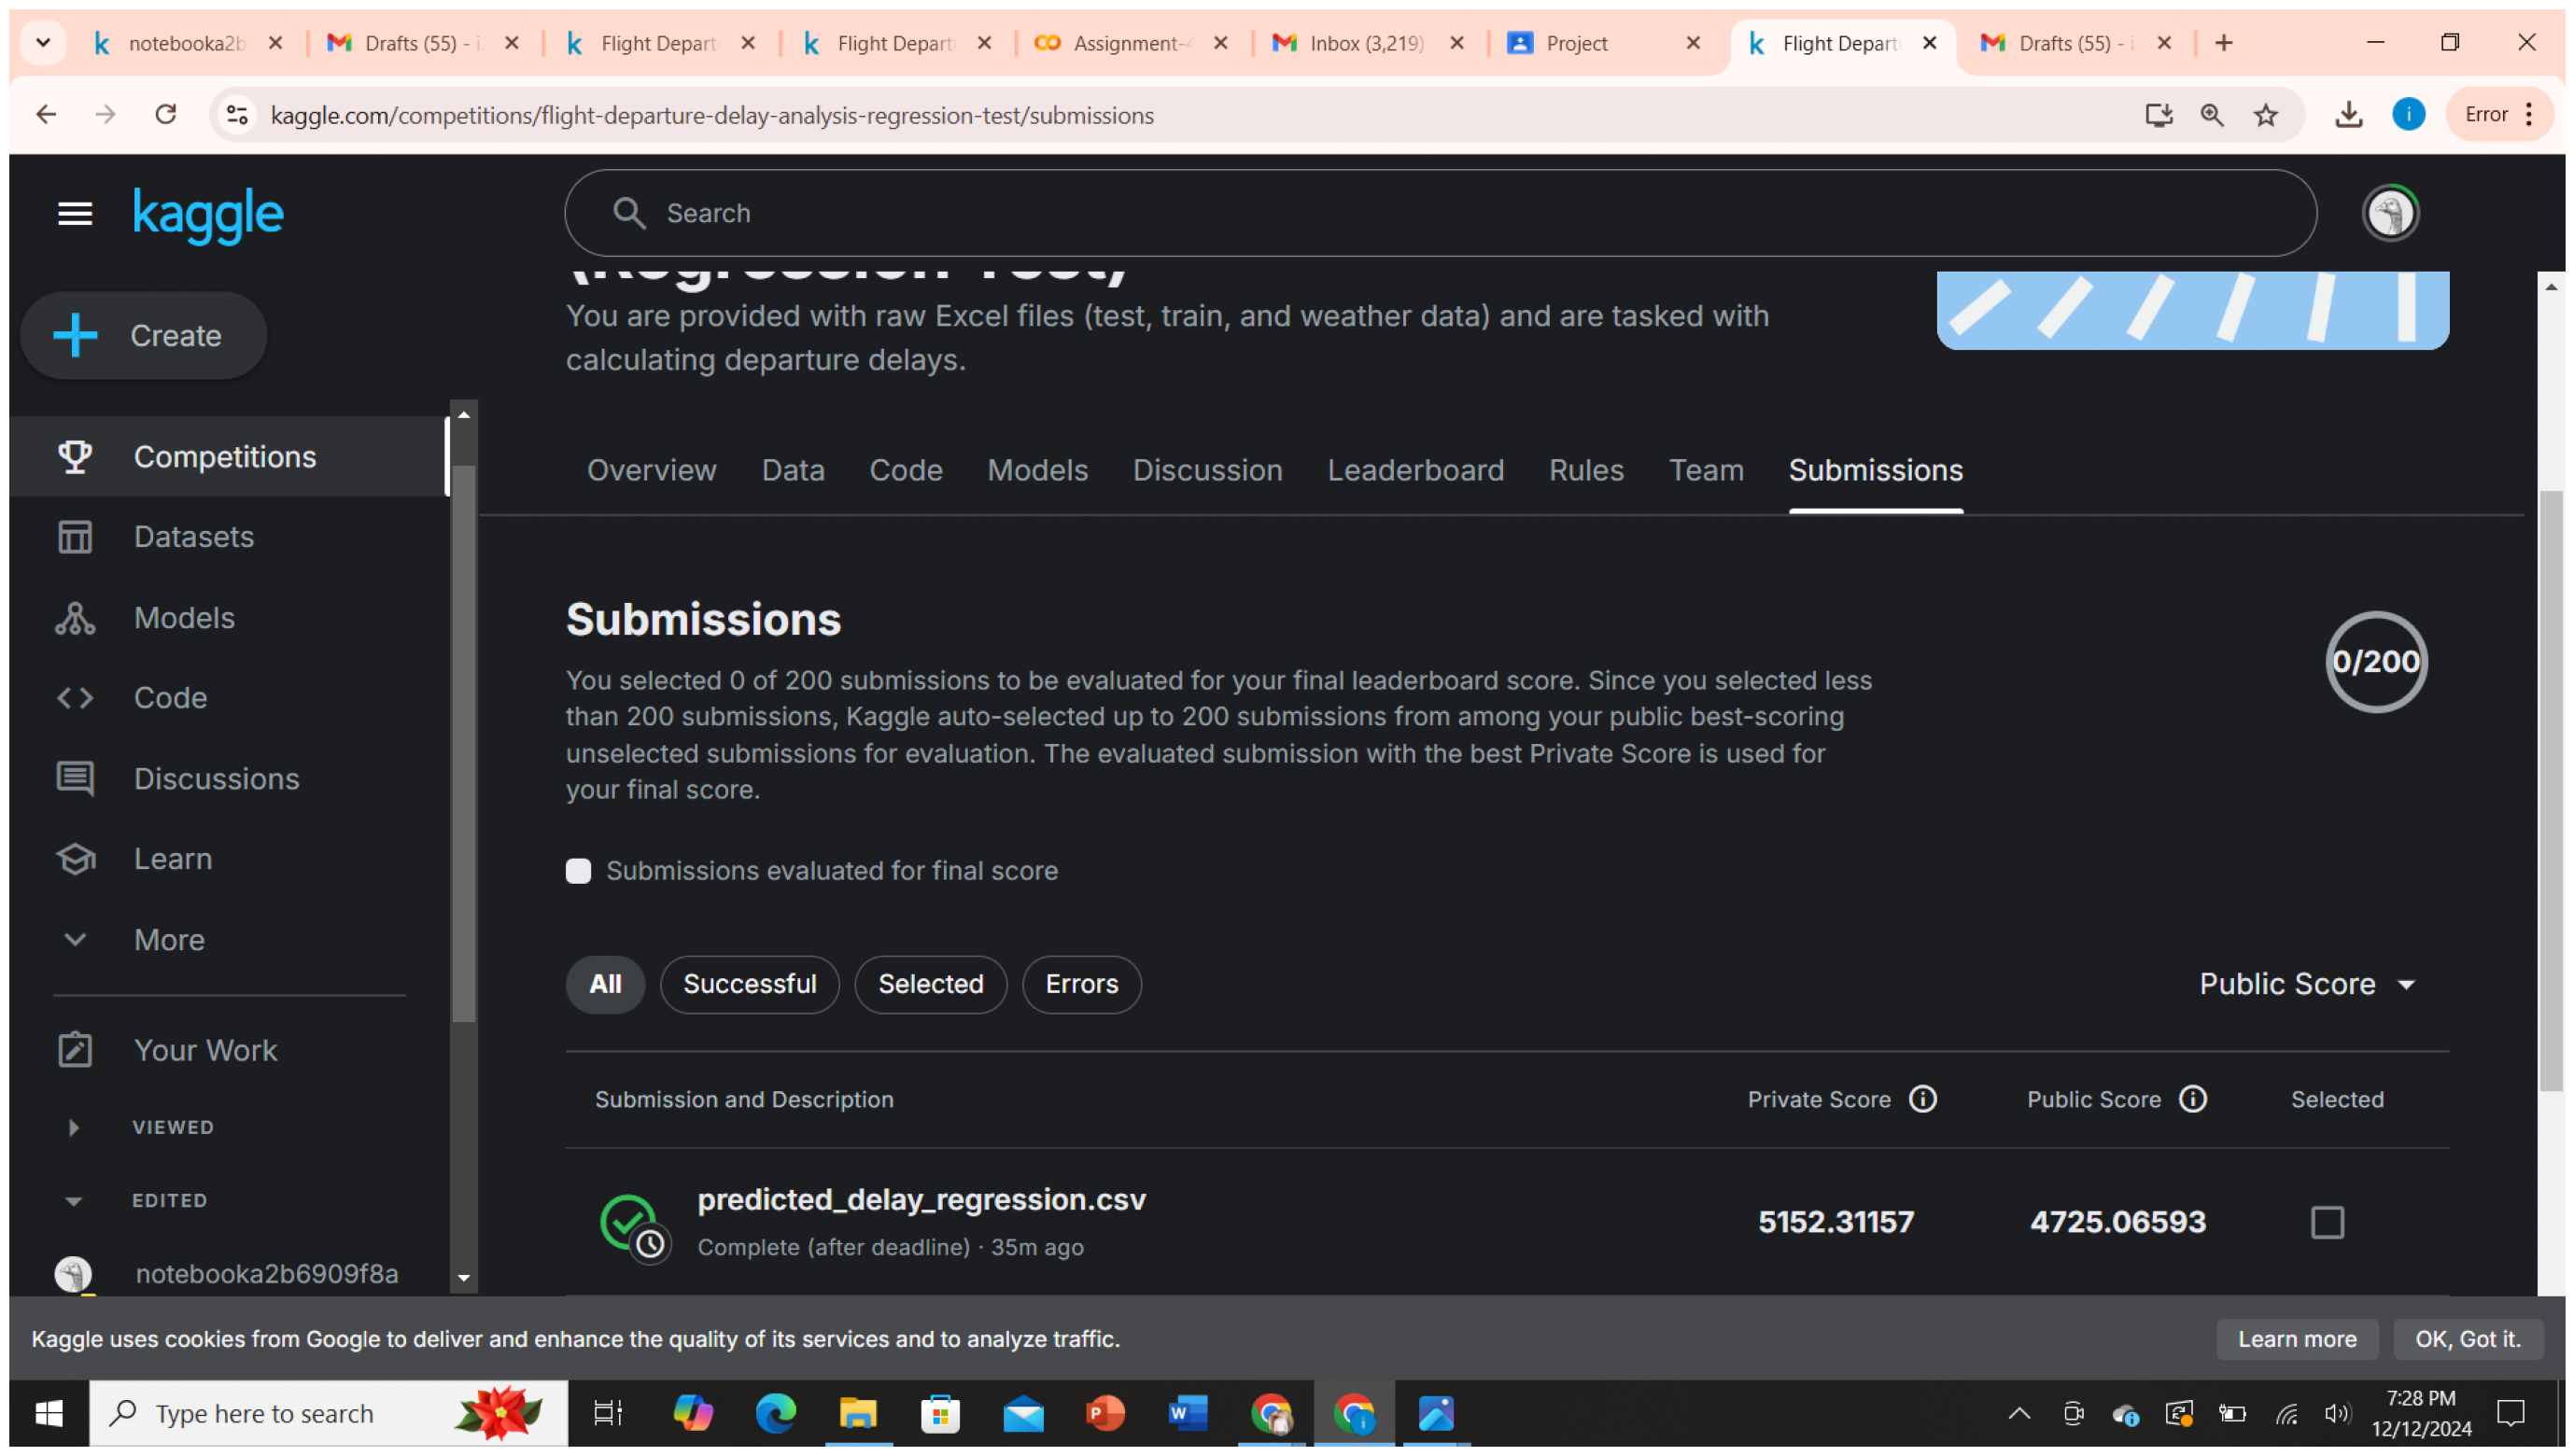

In [296]:
img = mpimg.imread('/kaggle/input/kaggleresult/Screenshot (5).png')
plt.figure(figsize=(40, 20)) 
plt.imshow(img)
plt.axis('off') 
plt.show()